In [1]:
# ================== 数据分析和可视化模块 ===================
import pandas as pd
import numpy as np
import polars as pl
import polars.selectors as ps
import seaborn as sns
import matplotlib.pyplot as plt

# ==================== 建模和调参模块 =======================
from collections import Counter
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from functools import partial
import optuna
from sklearn.preprocessing import (StandardScaler, MinMaxScaler,
                                   Normalizer, KBinsDiscretizer,
                                   FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier


# ====================== 自定义模块 =========================
from utils import kde_plot, joint_kde_2d_plot, seed_everything
from config import CONFIG
from metric import eval_metric_data, weighted_score_auto
from tuning import (
    lr_model_objective,
    lr_thr_model_objective,
    dt_model_objective,
    dt_thr_model_objective,
    xgb_model_objective,
    xgb_thr_model_objective,
)
from ml_module import LR_Threshold, DT_Threshold, XGB_Threshold

# ======================== 其他模块 =========================
import warnings
warnings.filterwarnings('ignore')

# **1. 数据集探索**

# **2. 数据探索**

In [2]:
data_pl = pl.read_csv("./data/creditcard.csv",
                      schema_overrides={'Time': pl.Float64})
data_pl

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.5516,-0.617801,-0.99139,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.16648,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.16717,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.37978,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.52498,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.1083,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.5,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.11967,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.20601,0.502292,0.219422,0.215153,69.99,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.35617,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.68292,1.475829,0.213454,0.111864,1.01448,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
172787.0,-0.732789,-0.05508,2.03503,-0.738589,0.868229,1.058415,0.02433,0.294869,0.5848,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
172788.0,1.919565,-0.301254,-3.24964,-0.557828,2.630515,3.03126,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0


## 2.1 字段介绍

## 2.2 数据质量探索

### 2.2.1 缺失值探索

In [3]:
data_pl.null_count()
# 发现并没有缺失值

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 2.3 字段探索 

### 2.3.1 离散字段

In [4]:
data_pl.select(ps.string())
# 发现不存在离散字段，因此无需对离散字段进行编码

shape: (0, 0)
┌┐
╞╡
└┘

### 2.3.2 时间字段

In [5]:
data_pl['Time']

Time
f64
0.0
0.0
1.0
1.0
2.0
…
172786.0
172787.0
172788.0


In [6]:
data_pl['Time'].describe()

statistic,value
str,f64
"""count""",284807.0
"""null_count""",0.0
"""mean""",94813.859575
"""std""",47488.145955
"""min""",0.0
"""25%""",54202.0
"""50%""",84692.0
"""75%""",139321.0
"""max""",172792.0


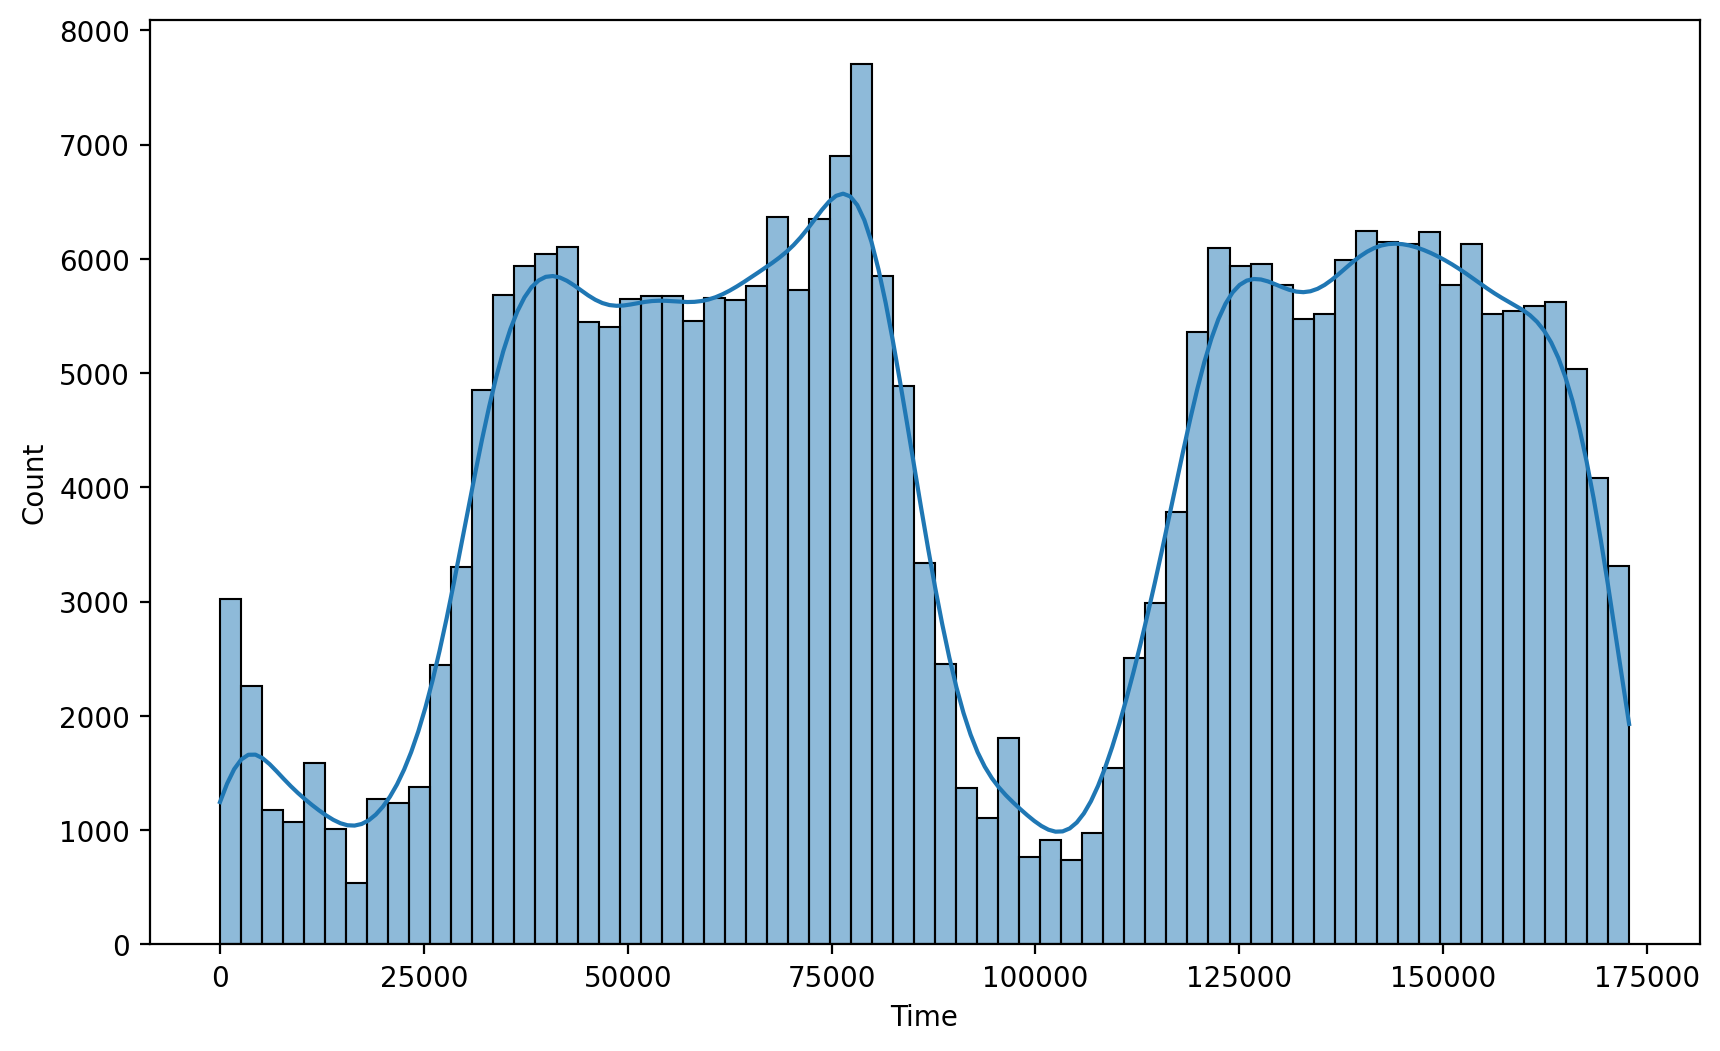

In [7]:
plt.figure(figsize=(10, 6), dpi=200)
sns.histplot(data=data_pl, x='Time', kde=True)
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()

### 2.3.3 数值字段

In [8]:
data_pl.select(ps.numeric().exclude('Time', 'Class'))

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.5516,-0.617801,-0.99139,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1.191857,0.266151,0.16648,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.16717,0.125895,-0.008983,0.014724,2.69
-1.358354,-1.340163,1.773209,0.37978,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.52498,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.1083,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.5
-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.11967,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.20601,0.502292,0.219422,0.215153,69.99
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.35617,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.68292,1.475829,0.213454,0.111864,1.01448,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
-0.732789,-0.05508,2.03503,-0.738589,0.868229,1.058415,0.02433,0.294869,0.5848,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
1.919565,-0.301254,-3.24964,-0.557828,2.630515,3.03126,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88


In [9]:
data_pl.select(ps.numeric().exclude('Time', 'Class')).describe()

statistic,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.1307e-15,3.6644e-16,-1.3449e-15,2.0458e-15,1.0307e-15,1.4924e-15,-5.9047e-16,8.7818e-17,-2.3695e-15,2.2651e-15,1.6655e-15,-1.2339e-15,8.0649e-16,1.1793e-15,4.8866e-15,1.4697e-15,-3.9748e-16,9.2533e-16,1.0161e-15,6.5863e-16,1.8043e-16,-3.2952e-16,2.3222e-16,4.4567e-15,4.9697e-16,1.7068e-15,-3.5062e-16,-1.1137e-16,88.349619
"""std""",1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.08885,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.62446,0.605647,0.521278,0.482227,0.403632,0.330083,250.120109
"""min""",-56.40751,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.49772,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.0
"""25%""",-0.920372,-0.598545,-0.890358,-0.848637,-0.691592,-0.768295,-0.554068,-0.208628,-0.643096,-0.535425,-0.762491,-0.405566,-0.648535,-0.425561,-0.582882,-0.468018,-0.483745,-0.49885,-0.456291,-0.211721,-0.22839,-0.542348,-0.161846,-0.354579,-0.317143,-0.326979,-0.070839,-0.052959,5.6
"""50%""",0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.02945,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.0
"""75%""",1.315648,0.803728,1.027201,0.743354,0.611927,0.398569,0.570446,0.327346,0.59714,0.453945,0.739596,0.61824,0.662507,0.49315,0.648823,0.523303,0.399677,0.50081,0.458951,0.133047,0.186384,0.528555,0.147642,0.439527,0.350716,0.240957,0.091046,0.078281,77.17
"""max""",2.45493,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.50309,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.16


## 2.4 target分布

In [10]:
(
    data_pl['Class']
    .value_counts()
    .with_columns(
        (pl.col('count') / pl.col('count').sum() * 100)
        .alias('percent(%)')
    )
)

Class,count,percent(%)
i64,u32,f64
1,492,0.172749
0,284315,99.827251


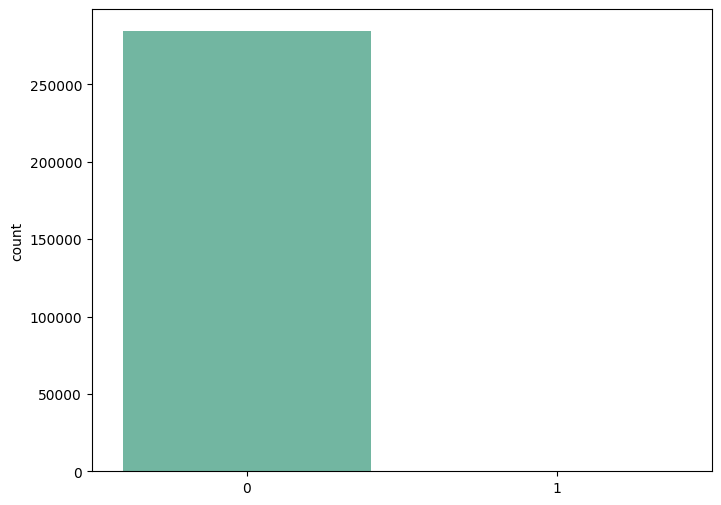

In [11]:
plt.figure(figsize=(8, 6), dpi=100)
sns.countplot(x=data_pl['Class'].to_numpy(), palette='Set2')
plt.show()
# 可以发现数据集极度不平衡

In [12]:
corr_pl = data_pl.corr()
corr_pl

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,0.117396,-0.010593,-0.419618,-0.10526,0.173072,-0.063016,0.084714,-0.036949,-0.00866,0.030617,-0.247689,0.124348,-0.065902,-0.098757,-0.183453,0.011903,-0.073297,0.090438,0.028975,-0.050866,0.044736,0.144059,0.051142,-0.016182,-0.233083,-0.041407,-0.005135,-0.009413,-0.010596,-0.012323
0.117396,1.0,-6.7014e-17,-5.9126e-16,-3.2884e-16,3.3773e-16,1.6986e-16,1.3537e-16,-8.3738e-17,4.5934e-17,7.3790e-17,2.7970e-16,1.9468e-16,-5.1536e-17,3.2315e-16,-1.0949e-16,2.6987e-16,-1.5851e-17,1.4824e-16,1.6114e-16,1.5491e-16,-9.8654e-17,8.4138e-17,1.6521e-16,-7.8855e-17,-2.1639e-16,-1.3700e-16,1.0464e-16,3.5744e-16,-0.227709,-0.101347
-0.010593,-6.7014e-17,1.0,7.0108e-17,-2.1046e-16,1.0524e-16,3.8300e-16,-1.4851e-16,-2.0391e-17,-1.0402e-16,-1.4403e-16,3.4269e-16,-3.2881e-16,-1.1961e-17,-3.8286e-16,4.7570e-17,5.3588e-17,-6.4552e-16,2.1306e-16,5.1271e-18,1.0622e-16,8.5566e-17,1.8827e-16,1.5168e-16,-1.2109e-16,1.8890e-16,2.4799e-16,-5.1615e-16,-3.6992e-16,-0.531409,0.091289
-0.419618,-5.9126e-16,7.0108e-17,1.0,-2.2880e-16,-5.4958e-16,1.4530e-15,2.6742e-16,3.5543e-18,9.1657e-18,1.7862e-16,1.2098e-16,2.8760e-16,-4.5380e-17,7.1060e-16,-5.3740e-17,5.9419e-16,1.0647e-16,3.6534e-16,3.4933e-16,-2.0575e-17,-1.4974e-16,-2.8572e-16,-8.2354e-17,2.4077e-17,7.0168e-17,-1.9731e-16,5.0034e-16,7.2027e-16,-0.21088,-0.192961
-0.10526,-3.2884e-16,-2.1046e-16,-2.2880e-16,1.0,-1.8491e-15,-4.2497e-16,-1.0017e-16,6.2052e-16,6.0453e-16,-1.5338e-16,-3.1528e-16,-2.3075e-16,-3.6349e-18,-1.1285e-16,2.1144e-16,-3.9117e-17,-3.6240e-16,-4.8483e-17,-2.8185e-16,-1.8903e-16,-5.0144e-17,2.3528e-16,2.0274e-16,1.5995e-16,6.4446e-16,-4.0227e-16,-1.0669e-16,-7.8905e-18,0.098732,0.133447
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.041407,-1.3700e-16,2.4799e-16,-1.9731e-16,-4.0227e-16,3.1912e-16,-2.5487e-16,-7.9972e-16,-4.7215e-18,-1.4706e-16,-3.7859e-16,-9.0249e-17,1.9245e-16,-1.4823e-16,-4.7243e-17,1.1287e-16,-4.4702e-16,2.8291e-16,2.8335e-16,5.4855e-16,-3.4398e-16,-5.0069e-16,-2.3611e-16,1.2774e-15,1.9772e-16,2.3406e-15,1.0,-2.7902e-16,-2.9330e-16,-0.003208,0.004455
-0.005135,1.0464e-16,-5.1615e-16,5.0034e-16,-1.0669e-16,4.5697e-16,-1.4502e-16,-1.6308e-16,2.8996e-16,-1.8826e-16,-3.1749e-16,-1.8034e-16,-3.1979e-16,-4.8764e-16,1.5515e-17,-1.2637e-15,8.1853e-16,7.1763e-16,2.3301e-16,-1.5801e-16,-9.8153e-16,-1.4140e-15,1.6969e-16,4.2478e-16,-3.0431e-16,-5.8672e-16,-2.7902e-16,1.0,4.6755e-17,0.028825,0.01758
-0.009413,3.5744e-16,-3.6992e-16,7.2027e-16,-7.8905e-18,-1.9047e-16,4.3794e-16,1.1975e-16,-5.5360e-16,8.1778e-16,2.4059e-16,-3.4812e-16,7.0505e-16,1.0837e-15,2.4276e-15,-1.1189e-15,7.0232e-16,-7.7843e-17,8.0841e-16,-1.3600e-15,-1.5629e-16,1.8599e-16,-5.3353e-16,1.3444e-15,-2.7270e-16,3.8122e-16,-2.9330e-16,4.6755e-17,1.0,0.010258,0.009536


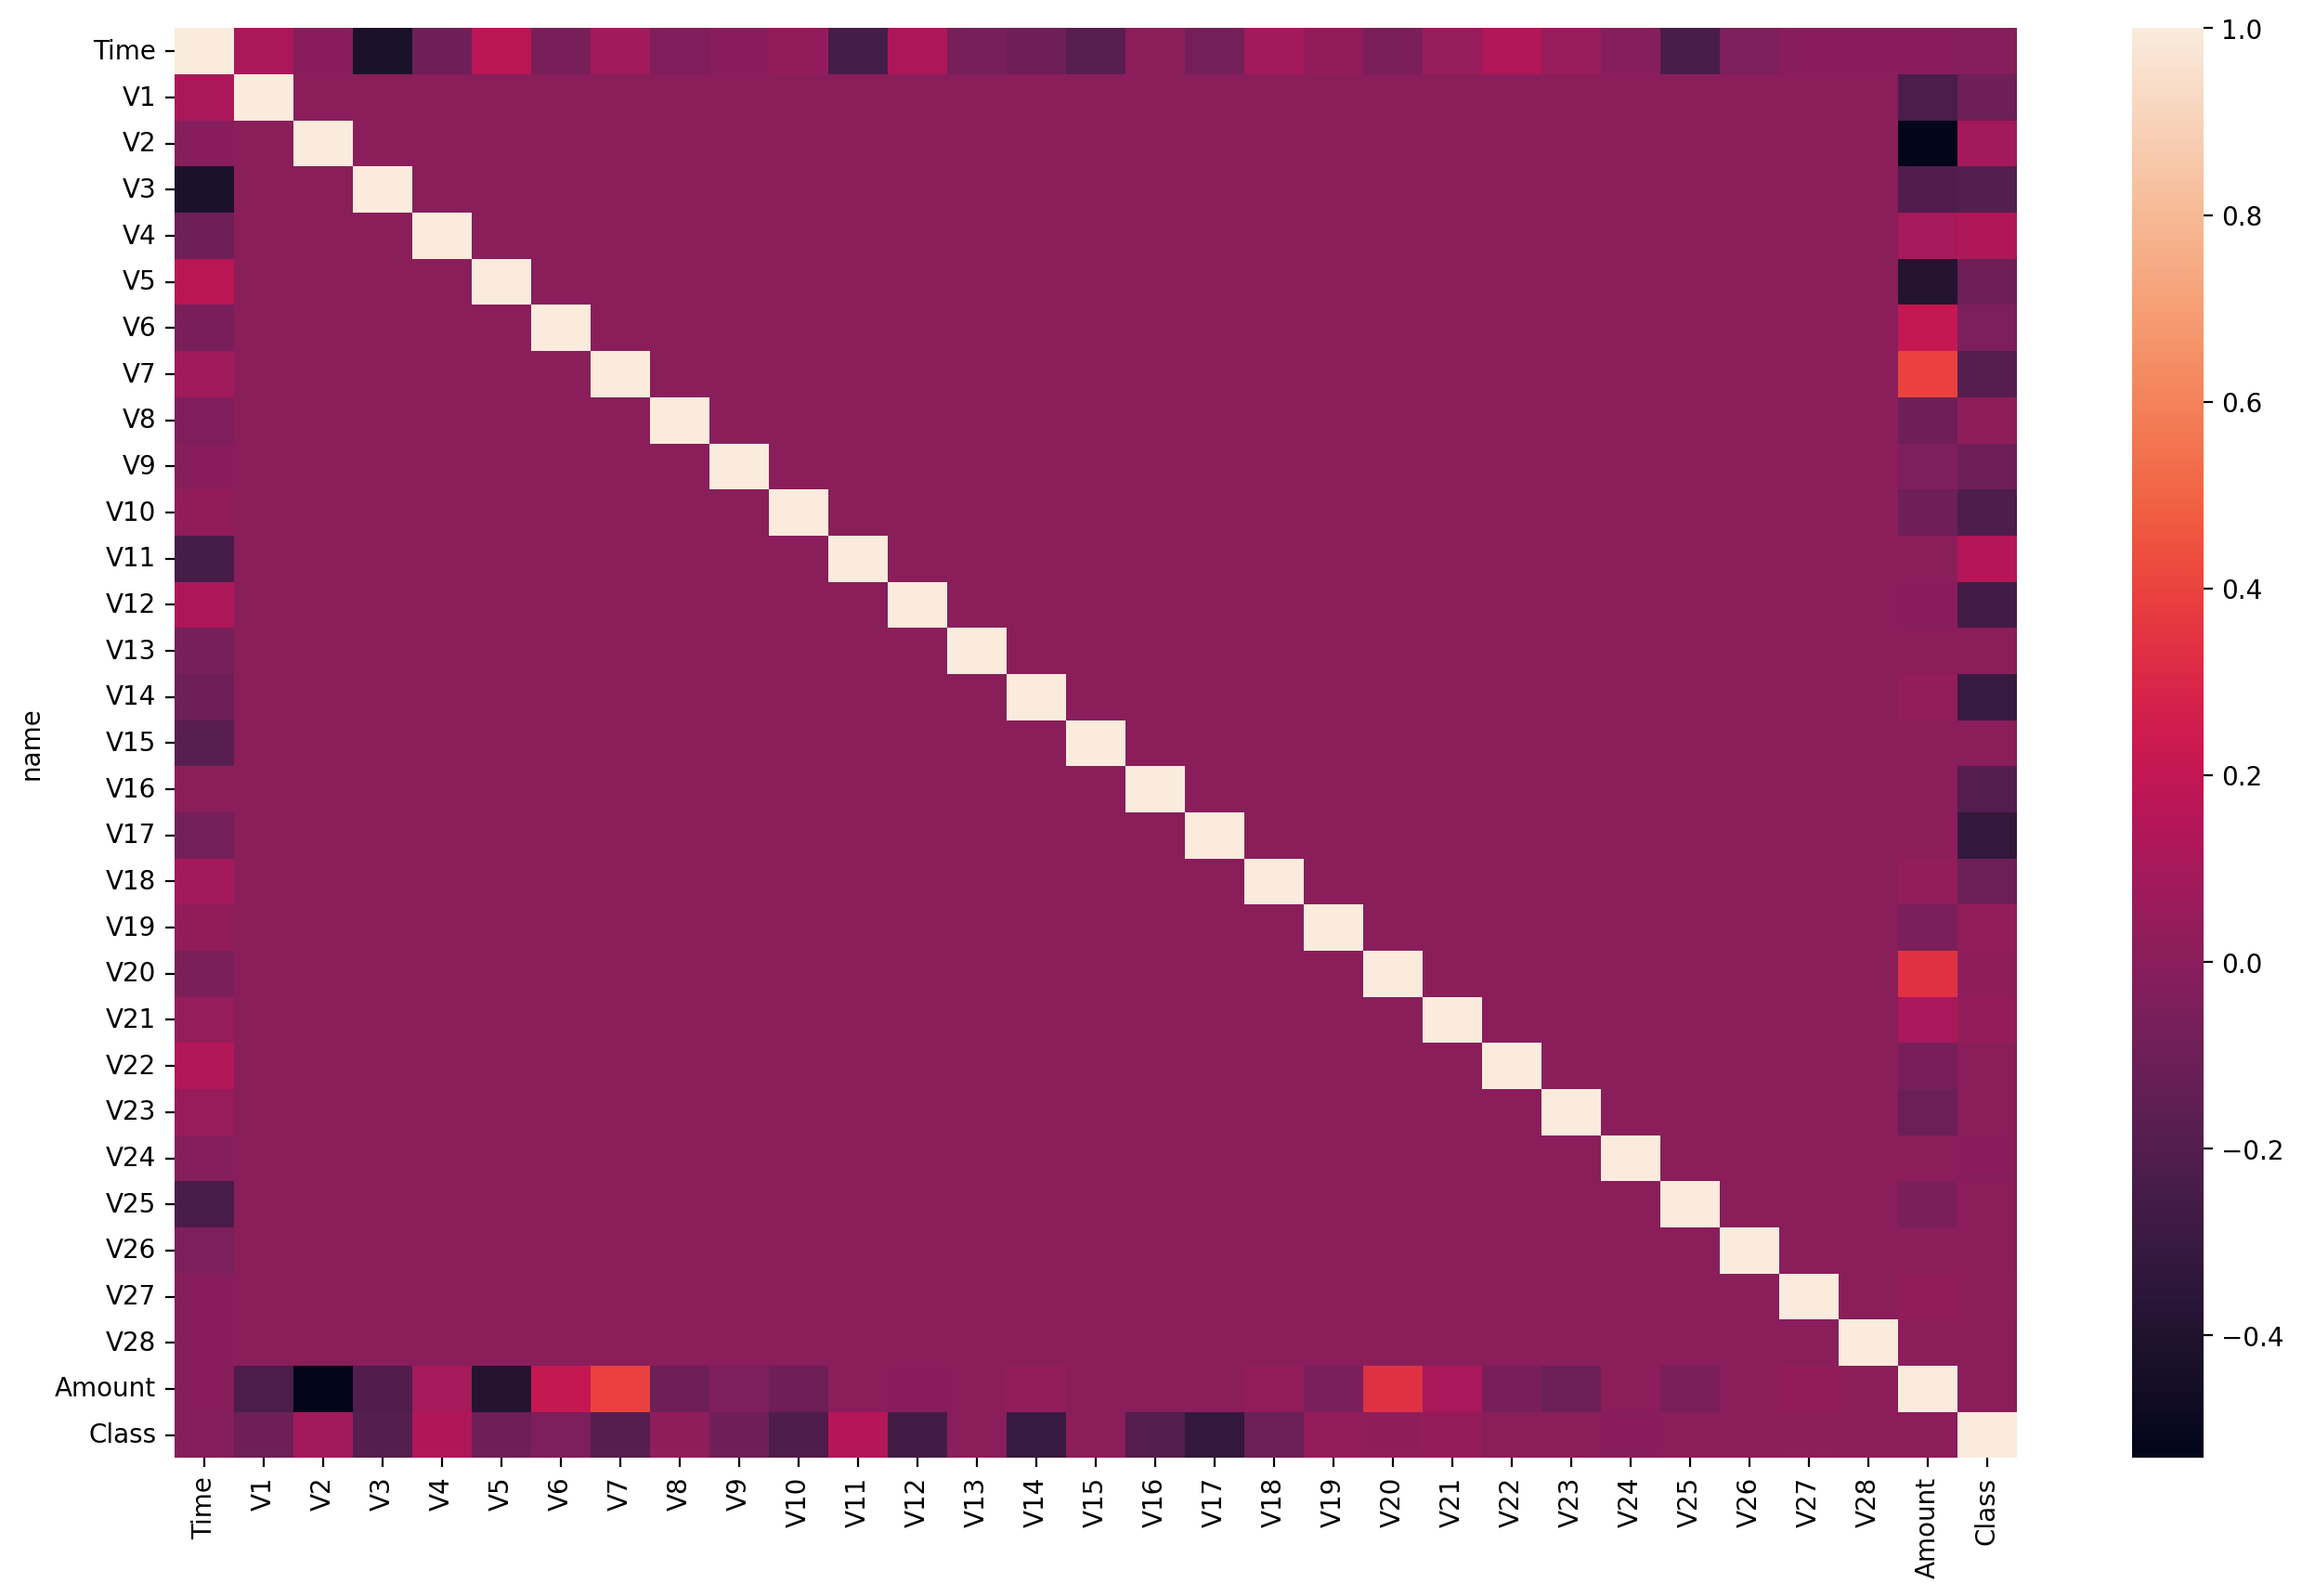

In [13]:
plt.figure(figsize=(16, 10), dpi=200)
sns.heatmap(
    (
        corr_pl
        .with_columns([
            pl.Series(corr_pl.columns).alias('name')
        ])
        .select(['name'] + corr_pl.columns)
        .to_pandas()
        .set_index('name')
    )
)
plt.show()

In [14]:
# 特征比较多，热力图也不清晰，下面把target和特征的相关性提取出来
target_corr_pl = (
    corr_pl
    .with_columns([
        pl.Series(corr_pl.columns).alias('name')
    ])
    .select(['name', "Class"])
    .sort(by='Class', descending=True)
)
target_corr_pl

name,Class
str,f64
"""Class""",1.0
"""V11""",0.154876
"""V4""",0.133447
"""V2""",0.091289
"""V21""",0.040413
…,…
"""V16""",-0.196539
"""V10""",-0.216883
"""V12""",-0.260593


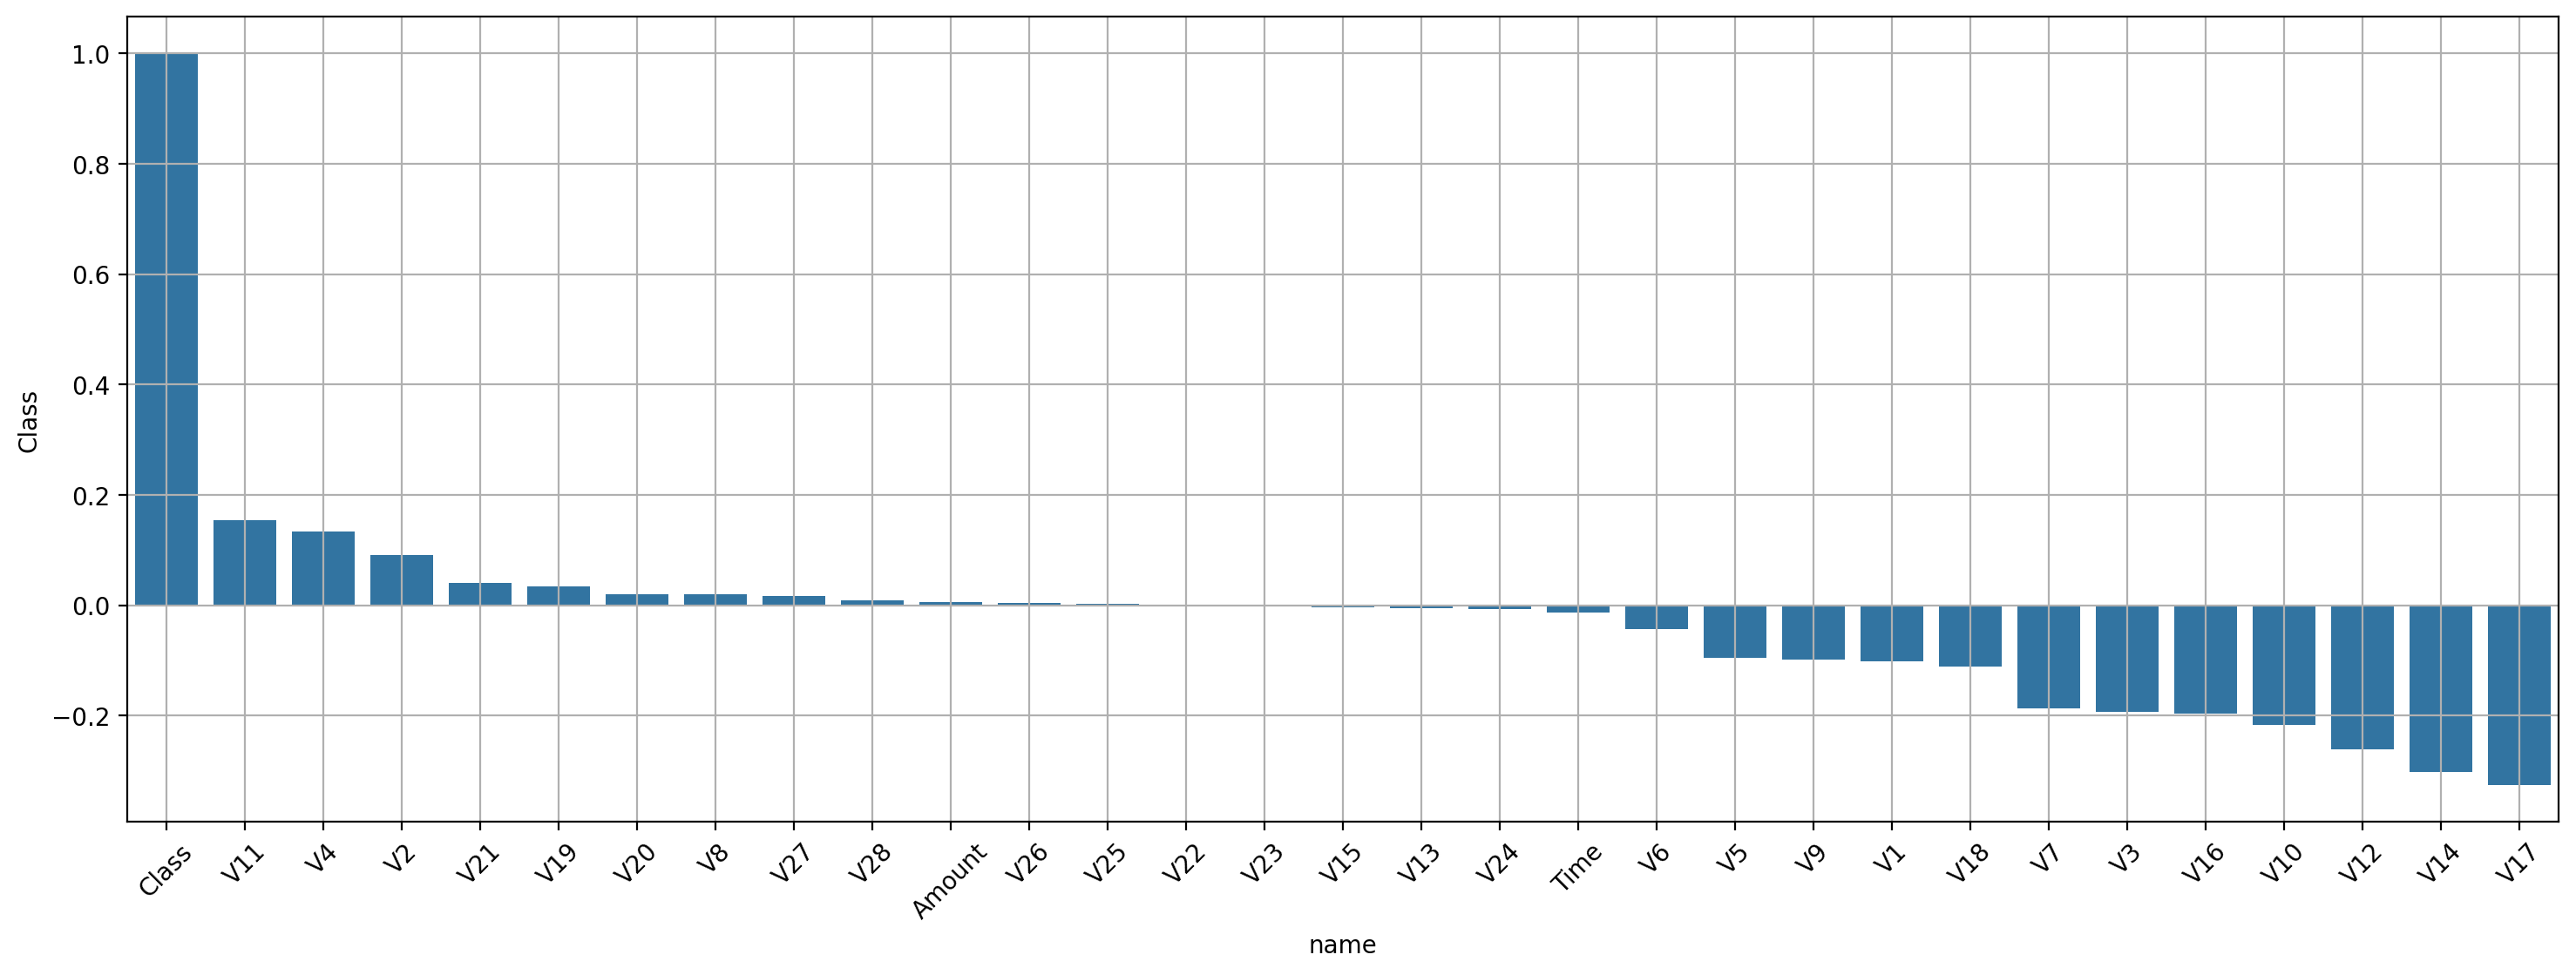

In [15]:
plt.figure(figsize=(18, 6), dpi=200)
sns.barplot(target_corr_pl.to_pandas(), x='name', y='Class')
plt.xticks(rotation=45)
plt.grid()
plt.show()

### 2.4.1 某些连续变量与target之间的分布

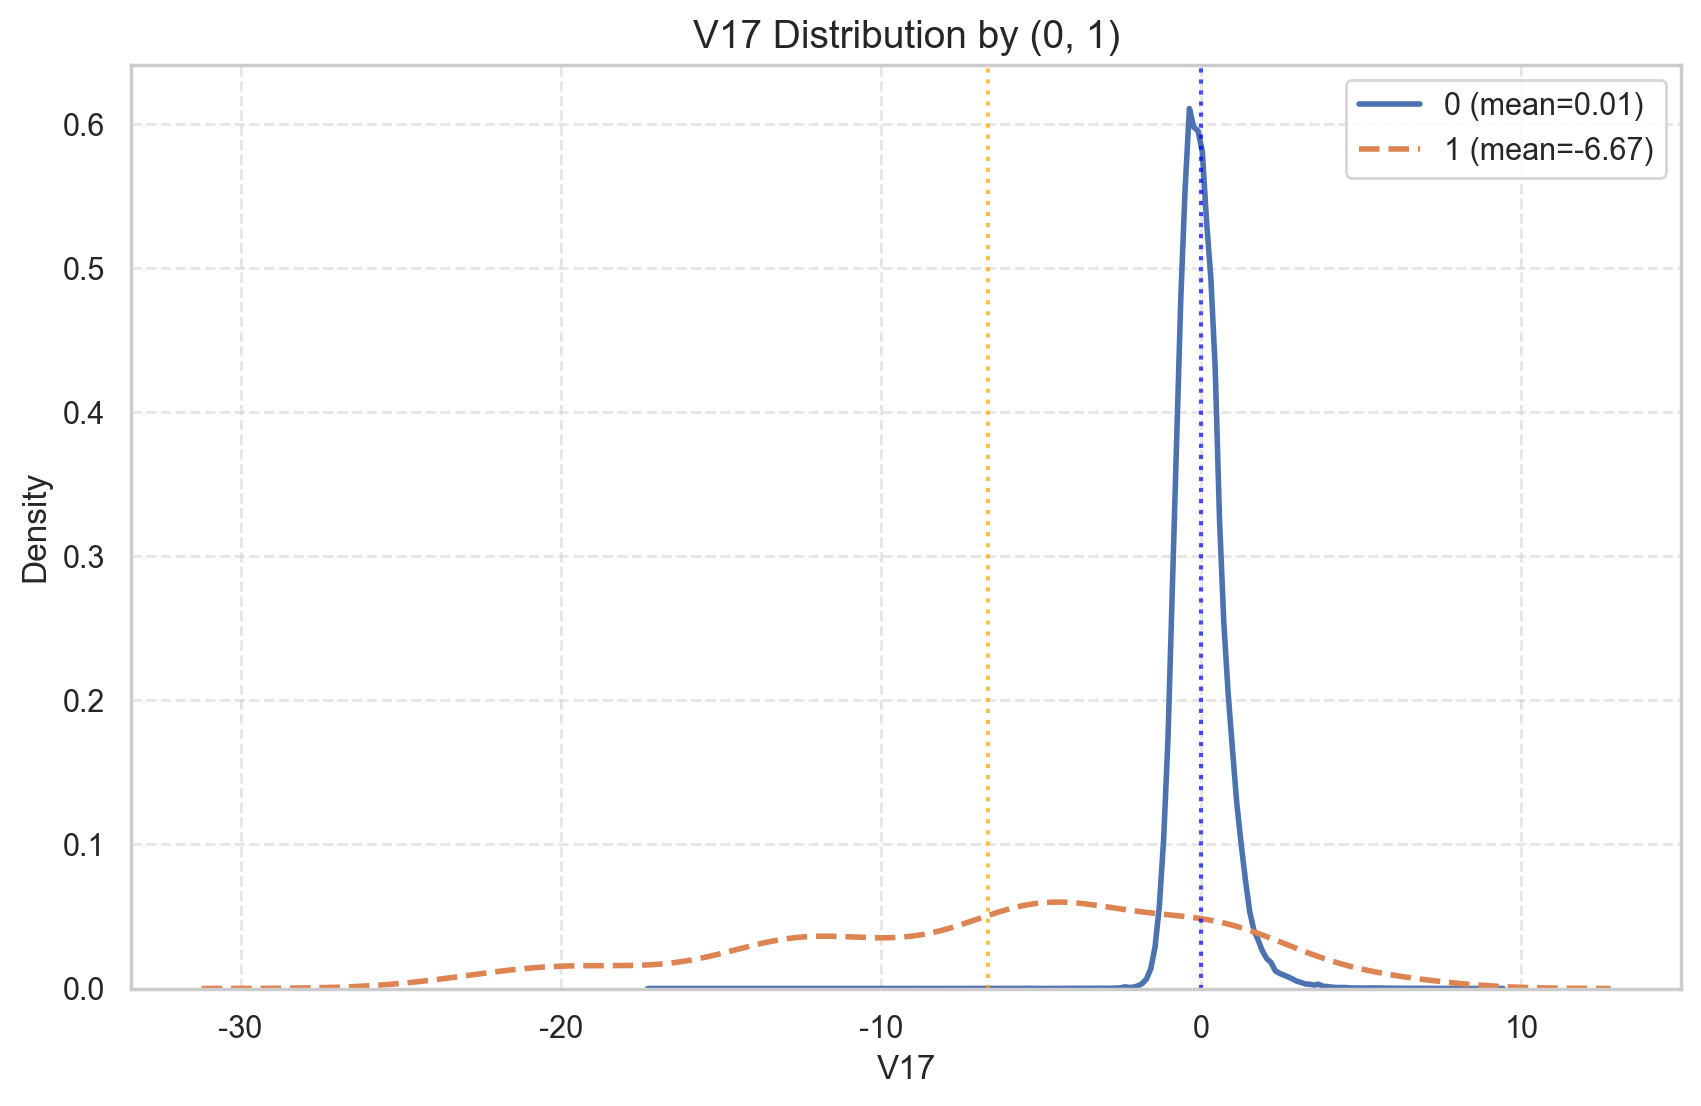

In [16]:
# 最强负相关特征
kde_plot(data_pl, 'V17', 'Class')

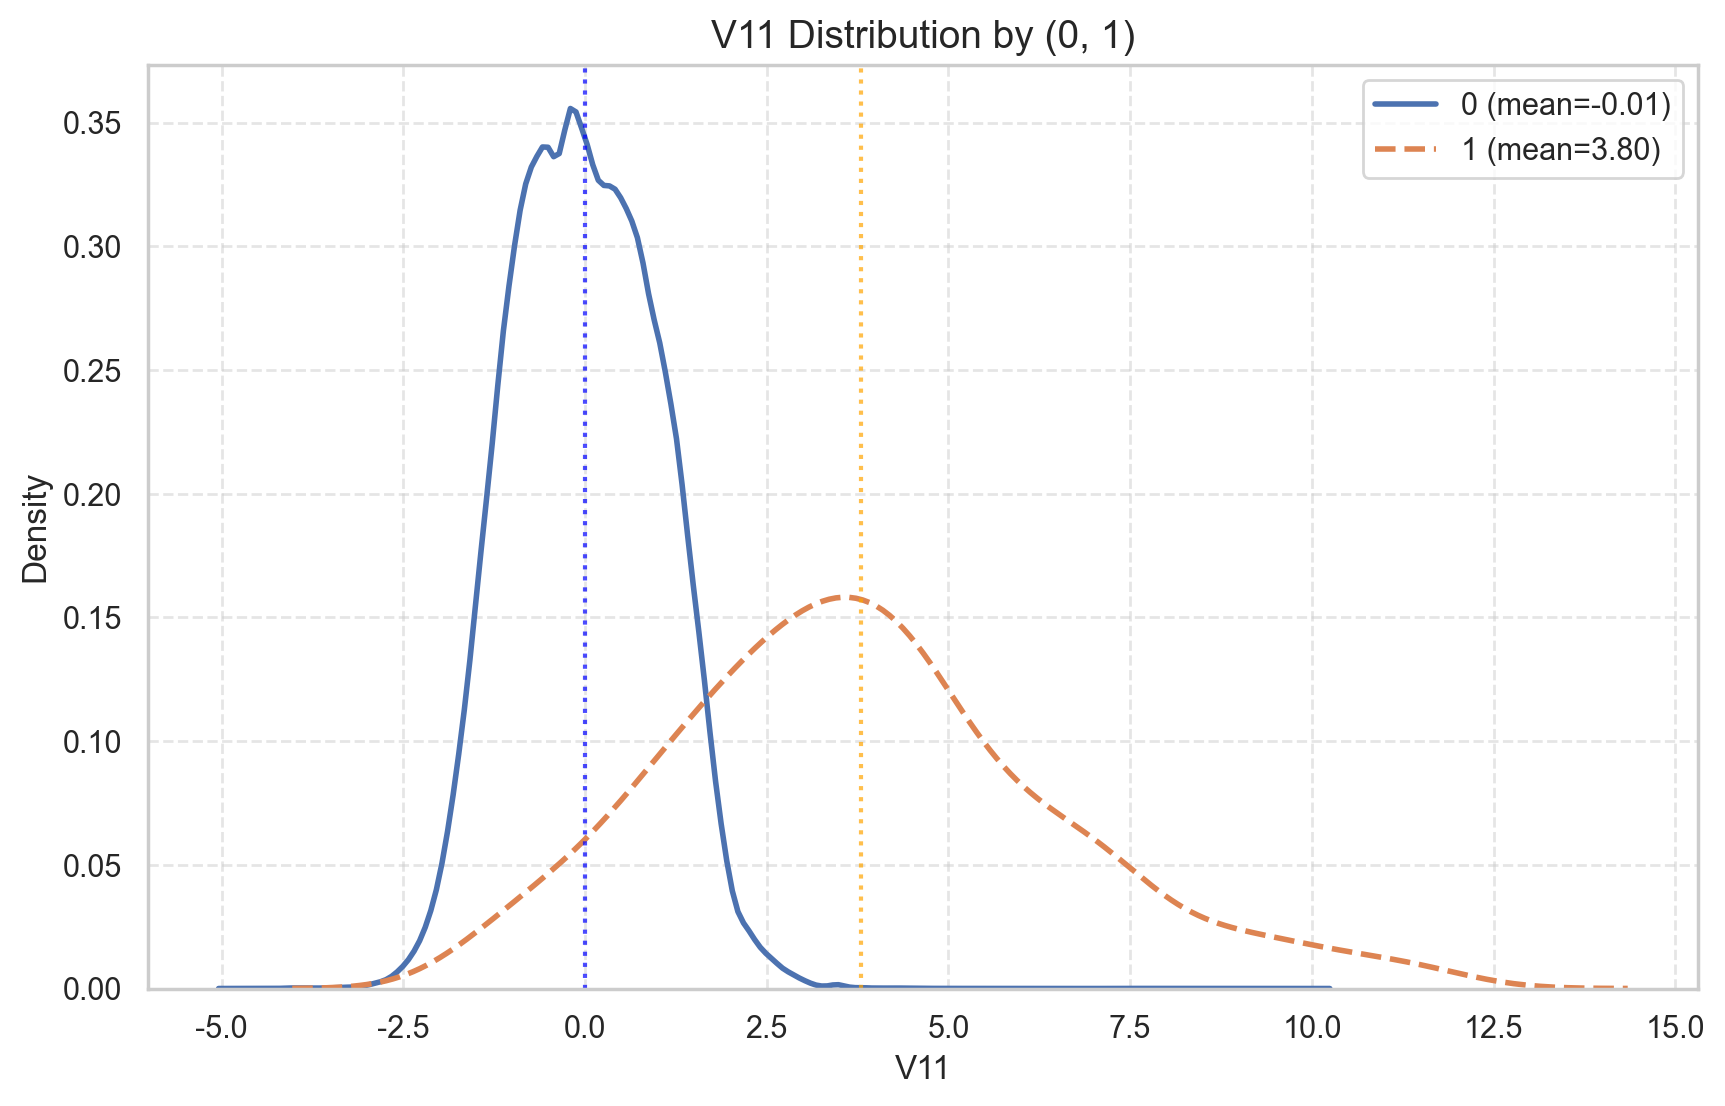

In [17]:
# 最强正相关特征
kde_plot(data_pl, 'V11', 'Class')

In [18]:
# # 查看二维联合密度热力图
# joint_kde_2d_plot(data_pl, 'V11', 'V4')
# joint_kde_2d_plot(data_pl, 'V17', 'V14')

# **3. 连续字段的特征变换**

## 3.1 标准化(按列处理)

In [19]:
train_data_pl, test_data_pl = train_test_split(
    data_pl,
    test_size=0.2,
    random_state=CONFIG.RANDOM_STATE,
    shuffle=True,
    stratify=data_pl[CONFIG.TARGET]
)

z_score_scalar = StandardScaler()
# 使用训练集数据进行拟合
z_score_scalar.fit(train_data_pl.select(CONFIG.NUMERIC_COLS).to_pandas())
# 使用训练集的统计量对测试集进行标准化
pl.DataFrame(
    z_score_scalar.transform(test_data_pl
                             .select(CONFIG.NUMERIC_COLS).to_pandas()),
    schema=list(z_score_scalar.feature_names_in_)
)

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.680982,-0.403991,-0.308652,0.262555,-1.720456,0.785774,3.005842,-1.119476,1.347761,-0.35329,-0.513077,-1.188295,-0.469318,-0.128315,-0.888967,-1.932996,1.344699,0.281947,-1.015669,0.740063,0.148218,0.363733,0.818083,-0.404026,1.748782,1.128458,-0.275264,-0.191031,-0.253433,-0.204292
0.787684,1.013782,-0.009265,-1.179661,0.423476,0.182595,-0.490526,-0.065299,-0.039605,0.648649,-0.446677,0.702643,0.258818,-1.024721,-1.415092,-1.050593,0.447691,1.137204,0.952723,0.286736,-0.275732,-0.007407,0.319376,-0.00807,-0.844484,0.122255,1.344193,-0.116108,-0.135466,-0.323451
-0.90938,-1.689532,-2.290828,-0.571883,-0.210744,-3.157452,1.553544,5.614038,-0.698028,-0.830723,-1.933203,0.040989,0.1476,1.374781,-0.156804,0.619855,0.386382,-0.709437,-0.629009,-1.647691,4.990474,1.118794,-0.48294,6.359544,-0.102869,0.620171,1.238601,-1.198193,0.215596,6.475916
0.75404,0.359399,-1.258253,-2.059146,0.621886,0.011013,-0.95363,1.497912,-0.579337,-0.202353,-0.076795,0.969522,0.814594,-0.586624,1.395899,-0.71762,-0.932444,-0.253564,0.049788,0.066623,1.470637,1.064712,1.131332,-1.344235,0.204632,0.954957,0.057877,-0.522076,0.080607,2.480537
1.131039,-0.444068,-0.255308,1.540542,-1.375393,-0.591755,0.333318,-0.261252,0.291533,-0.462535,-0.3503,-1.734713,-1.306009,-0.72157,-0.472455,0.75474,-0.246835,-0.995186,2.561696,-2.154383,-0.420199,-0.169794,-0.24405,-0.152907,0.704999,0.433997,1.320696,-0.026034,0.219496,-0.010207
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-1.91982,0.738684,-0.354807,-0.57753,-1.156634,1.069879,2.442135,-0.965059,0.599505,0.331111,0.270319,0.989405,-3.177106,1.874847,1.465176,0.280458,1.744019,0.525797,-1.03992,0.95445,0.211089,-0.401794,-1.215708,0.169907,1.515538,0.70436,-1.048699,-0.035425,0.030139,-0.298793
-0.14995,-0.101044,0.565873,0.095181,-0.458354,0.266692,-0.792734,0.715351,-0.092419,0.272117,-0.071644,-1.057635,-0.367187,-0.946457,0.243624,-0.249308,-0.122242,-0.386849,-0.851366,-0.18669,0.022126,-0.411305,-0.912222,0.130108,-0.198339,-0.916361,0.322302,0.865301,0.449668,-0.344098
-0.898684,-0.538999,0.451313,0.553064,0.170777,0.146776,0.227889,0.460656,0.538349,-0.527733,-0.792678,0.376387,0.818447,-0.523596,0.525353,-1.61673,-0.138327,-0.236697,-0.198928,-0.687594,-0.190778,0.192582,0.31645,0.02487,-0.524744,-0.083345,-1.10827,0.010096,0.158089,-0.029583


In [20]:
# 错误做法：直接对测试集进行标准化
pl.DataFrame(
    z_score_scalar.fit_transform(test_data_pl.select(CONFIG.NUMERIC_COLS).to_pandas()),
    schema=list(z_score_scalar.feature_names_in_)
)

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.669154,-0.420321,-0.326244,0.25629,-1.732134,0.812418,3.056883,-1.193806,1.364382,-0.353739,-0.517839,-1.192501,-0.461239,-0.133468,-0.880567,-1.939611,1.351732,0.271643,-1.016324,0.734922,0.150007,0.360185,0.818126,-0.391079,1.754851,1.133587,-0.270647,-0.205746,-0.293854,-0.209584
0.800855,1.051053,-0.015921,-1.216676,0.428279,0.18555,-0.499112,-0.069809,-0.039619,0.64704,-0.450611,0.698739,0.269048,-1.027847,-1.406584,-1.055593,0.449705,1.13485,0.943913,0.28598,-0.297893,-0.010591,0.317987,-0.001339,-0.844597,0.124887,1.349893,-0.125025,-0.155459,-0.333041
-0.89776,-1.754465,-2.380829,-0.595939,-0.210817,-3.285666,1.579817,5.985672,-0.705936,-0.83062,-1.955668,0.036979,0.157501,1.366228,-0.148555,0.617912,0.388054,-0.728956,-0.631266,-1.629738,5.26581,1.114506,-0.486631,6.266329,-0.101214,0.624038,1.24423,-1.29085,0.256392,6.711559
0.767179,0.37193,-1.310534,-2.114912,0.628213,0.00723,-0.970114,1.596933,-0.585822,-0.202977,-0.076118,0.96566,0.826466,-0.590741,1.403829,-0.722011,-0.938151,-0.268846,0.044718,0.067996,1.547131,1.060477,1.132274,-1.316531,0.20702,0.959656,0.062717,-0.56241,0.098029,2.572079
1.144523,-0.461914,-0.270952,1.561525,-1.384419,-0.61921,0.338782,-0.278741,0.295489,-0.462857,-0.353032,-1.739006,-1.300402,-0.725381,-0.464141,0.753044,-0.248707,-1.017362,2.546219,-2.131529,-0.450522,-0.172819,-0.247056,-0.143902,0.70858,0.437402,1.32638,-0.02798,0.260967,-0.008499
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-1.909123,0.765554,-0.374085,-0.601706,-1.163978,1.10768,2.483563,-1.029162,0.607154,0.32987,0.275324,0.985547,-3.177026,1.865163,1.473092,0.277894,1.753287,0.517759,-1.040474,0.947236,0.216429,-0.404592,-1.221504,0.173844,1.521051,0.708436,-1.044599,-0.038097,0.038821,-0.307494
-0.137636,-0.105921,0.580227,0.085347,-0.46033,0.27295,-0.806474,0.762543,-0.093067,0.270944,-0.070903,-1.061821,-0.358806,-0.94976,0.251791,-0.252841,-0.123416,-0.40337,-0.852702,-0.182868,0.016791,-0.414094,-0.917146,0.134671,-0.196912,-0.916308,0.327319,0.932334,0.530996,-0.354433
-0.887055,-0.560433,0.461482,0.552993,0.173637,0.148325,0.231555,0.49098,0.545265,-0.52798,-0.800925,0.372431,0.83033,-0.527856,0.533462,-1.622767,-0.139591,-0.251823,-0.202967,-0.678926,-0.20814,0.189201,0.315053,0.031084,-0.524095,-0.081224,-1.10421,0.010946,0.188927,-0.028575


## 3.2 归一化(按行处理)

In [21]:
normalizer_scaler = Normalizer(norm='l2')
# Normalizer是对数据集的每一行进行归一化
pl.DataFrame(
    normalizer_scaler.fit_transform(test_data_pl.select(CONFIG.NUMERIC_COLS).to_pandas()),
    schema=list(normalizer_scaler.feature_names_in_)
)

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,-0.000013,-0.000008,0.000006,-0.000039,0.000017,0.000064,-0.000022,0.000026,-0.000006,-0.000009,-0.000019,-0.000007,-0.000002,-0.000014,-0.000028,0.000019,0.000004,-0.000014,0.00001,0.000002,0.000004,0.000009,-0.000004,0.000017,0.000009,-0.000002,-0.000001,-0.000001,0.000591
1.0,0.000015,-1.3173e-7,-0.000014,0.000005,0.000002,-0.000005,-6.1820e-7,-3.5744e-7,0.000005,-0.000004,0.000005,0.000002,-0.000008,-0.00001,-0.000007,0.000003,0.000007,0.000006,0.000002,-0.000002,-4.4645e-8,0.000002,-3.1644e-8,-0.000004,4.8361e-7,0.000005,-3.5908e-7,-3.4599e-7,0.000053
0.999448,-0.000064,-0.000074,-0.000017,-0.000006,-0.000085,0.00004,0.000136,-0.000016,-0.000018,-0.000041,7.9237e-7,0.000003,0.000026,-0.000003,0.000011,0.000007,-0.000012,-0.00001,-0.000026,0.000075,0.000016,-0.000007,0.000076,-0.000001,0.000006,0.000012,-0.000009,0.000001,0.033213
0.999985,0.000005,-0.000016,-0.000024,0.000007,1.0850e-7,-0.00001,0.000014,-0.000005,-0.000002,-6.3841e-7,0.000008,0.000006,-0.000004,0.00001,-0.000005,-0.000006,-0.000002,3.1265e-7,4.1652e-7,0.000009,0.000006,0.000006,-0.000006,9.5010e-7,0.000004,2.1703e-7,-0.000002,2.1084e-7,0.005455
1.0,-0.000006,-0.000003,0.000016,-0.000013,-0.000006,0.000003,-0.000002,0.000002,-0.000003,-0.000003,-0.000012,-0.000009,-0.000005,-0.000003,0.000005,-0.000001,-0.000006,0.000014,-0.000012,-0.000002,-8.4198e-7,-0.000001,-6.3466e-7,0.000003,0.000002,0.000004,-7.1655e-8,5.0264e-7,0.000578
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.999992,0.000389,-0.000158,-0.000236,-0.000437,0.000397,0.000871,-0.000322,0.000192,0.000097,0.000079,0.000269,-0.000847,0.000497,0.000375,0.000068,0.000408,0.000119,-0.000233,0.000207,0.000044,-0.000079,-0.000236,0.000028,0.000245,0.000098,-0.000135,-0.000004,0.000003,0.003522
1.0,-0.000002,0.000011,0.000002,-0.000007,0.000004,-0.000012,0.00001,-0.000001,0.000003,-8.8656e-7,-0.000012,-0.000004,-0.000011,0.000003,-0.000003,-0.000001,-0.000004,-0.000008,-0.000002,1.8525e-7,-0.000003,-0.000008,9.3181e-7,-0.000001,-0.000005,0.000002,0.000004,0.000002,0.00002
0.999999,-0.00002,0.000014,0.000016,0.000005,0.000004,0.000006,0.000011,0.000012,-0.000011,-0.000017,0.000007,0.000016,-0.00001,0.00001,-0.000028,-0.000002,-0.000004,-0.000003,-0.000011,-0.000003,0.000003,0.000004,3.1228e-7,-0.000006,-8.2731e-7,-0.00001,7.9195e-8,0.000001,0.00155


## 4.3 特征分箱

对连续型字段进行离散化处理  
对于很多线性模型来说，连续变量的分箱实际上相当于在线性模型中引入非线性因素，从而提升模型表现；  
但连续变量分箱过程会让连续变量损失一些信息，对于其他很多模型（如树模型），分箱损失的信息则大概率会影响最终模型效果。  

### 4.3.1 等宽分箱

In [22]:
uniform_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
uniform_discretizer.fit(train_data_pl.select(CONFIG.NUMERIC_COLS))
pl.DataFrame(
    uniform_discretizer.transform(test_data_pl.select(CONFIG.NUMERIC_COLS)),
    schema=[f"{col}_uniform" for col in uniform_discretizer.feature_names_in_]
)

Time_uniform,V1_uniform,V2_uniform,V3_uniform,V4_uniform,V5_uniform,V6_uniform,V7_uniform,V8_uniform,V9_uniform,V10_uniform,V11_uniform,V12_uniform,V13_uniform,V14_uniform,V15_uniform,V16_uniform,V17_uniform,V18_uniform,V19_uniform,V20_uniform,V21_uniform,V22_uniform,V23_uniform,V24_uniform,V25_uniform,V26_uniform,V27_uniform,V28_uniform,Amount_uniform
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,4.0,3.0,4.0,0.0,3.0,1.0,1.0,4.0,2.0,2.0,1.0,3.0,2.0,3.0,1.0,2.0,3.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,1.0,0.0
3.0,4.0,3.0,4.0,1.0,3.0,1.0,1.0,3.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,2.0,1.0,0.0
1.0,4.0,3.0,4.0,1.0,3.0,1.0,1.0,3.0,2.0,2.0,1.0,3.0,2.0,3.0,1.0,2.0,3.0,3.0,2.0,3.0,2.0,2.0,3.0,1.0,2.0,2.0,2.0,1.0,0.0
3.0,4.0,3.0,3.0,1.0,3.0,1.0,1.0,3.0,2.0,2.0,1.0,3.0,2.0,3.0,1.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,2.0,1.0,0.0
4.0,4.0,3.0,4.0,0.0,3.0,1.0,1.0,3.0,2.0,2.0,0.0,3.0,1.0,3.0,1.0,2.0,3.0,4.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,1.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.0,4.0,3.0,4.0,0.0,3.0,1.0,1.0,3.0,2.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,3.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,2.0,1.0,0.0
2.0,4.0,3.0,4.0,1.0,3.0,1.0,1.0,3.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,2.0,1.0,0.0
1.0,4.0,3.0,4.0,1.0,3.0,1.0,1.0,3.0,2.0,2.0,1.0,3.0,2.0,3.0,1.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,1.0,2.0,1.0,0.0


In [23]:
# 查看边界
uniform_discretizer.bin_edges_

array([array([     0. ,  34558.4,  69116.8, 103675.2, 138233.6, 172792. ]),
       array([-56.40750963, -44.63502171, -32.86253378, -21.09004586,
               -9.31755793,   2.45492999])                           ,
       array([-72.71572756, -53.76103625, -34.80634494, -15.85165363,
                3.10303768,  22.05772899])                           ,
       array([-48.32558936, -36.7839598 , -25.24233024, -13.70070069,
               -2.15907113,   9.38255843])                           ,
       array([-5.6831712 , -1.17146815,  3.34023489,  7.85193794, 12.36364099,
              16.87534403])                                                   ,
       array([-113.74330671,  -84.03431219,  -54.32531768,  -24.61632316,
                 5.09267136,   34.80166588])                             ,
       array([-26.16050594,  -6.26807964,  13.62434666,  33.51677295,
               53.40919925,  73.30162555])                           ,
       array([-43.55724157, -10.72789447,  22.101452

### 4.3.2 等频分箱

In [24]:
quantile_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
quantile_discretizer.fit(train_data_pl.select(CONFIG.NUMERIC_COLS))
pl.DataFrame(
    quantile_discretizer.transform(test_data_pl.select(CONFIG.NUMERIC_COLS)),
    schema=[f"{col}_quantile" for col in quantile_discretizer.feature_names_in_]
)

Time_quantile,V1_quantile,V2_quantile,V3_quantile,V4_quantile,V5_quantile,V6_quantile,V7_quantile,V8_quantile,V9_quantile,V10_quantile,V11_quantile,V12_quantile,V13_quantile,V14_quantile,V15_quantile,V16_quantile,V17_quantile,V18_quantile,V19_quantile,V20_quantile,V21_quantile,V22_quantile,V23_quantile,V24_quantile,V25_quantile,V26_quantile,V27_quantile,V28_quantile,Amount_quantile
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,1.0,1.0,2.0,0.0,4.0,4.0,0.0,4.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,4.0,3.0,0.0,4.0,3.0,4.0,3.0,0.0,4.0,4.0,2.0,1.0,0.0,2.0
3.0,4.0,2.0,0.0,3.0,3.0,1.0,2.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0,0.0,3.0,4.0,4.0,3.0,1.0,2.0,3.0,2.0,0.0,2.0,4.0,1.0,1.0,1.0
1.0,0.0,0.0,1.0,2.0,0.0,4.0,4.0,0.0,0.0,0.0,2.0,2.0,4.0,1.0,3.0,3.0,0.0,1.0,0.0,4.0,4.0,1.0,4.0,1.0,3.0,4.0,0.0,3.0,4.0
3.0,2.0,0.0,0.0,3.0,2.0,0.0,4.0,0.0,2.0,2.0,4.0,4.0,1.0,4.0,1.0,0.0,2.0,2.0,2.0,4.0,4.0,4.0,0.0,2.0,4.0,2.0,0.0,3.0,4.0
4.0,1.0,1.0,4.0,0.0,1.0,3.0,1.0,3.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,4.0,0.0,0.0,1.0,2.0,1.0,3.0,3.0,4.0,2.0,3.0,3.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.0,3.0,1.0,1.0,0.0,4.0,4.0,0.0,4.0,3.0,3.0,4.0,0.0,4.0,4.0,2.0,4.0,3.0,0.0,4.0,3.0,0.0,0.0,3.0,4.0,3.0,0.0,2.0,2.0,2.0
2.0,2.0,3.0,2.0,1.0,3.0,0.0,4.0,1.0,3.0,2.0,0.0,1.0,0.0,3.0,1.0,2.0,1.0,0.0,2.0,3.0,0.0,0.0,3.0,1.0,0.0,3.0,4.0,4.0,0.0
1.0,1.0,3.0,3.0,2.0,3.0,3.0,3.0,4.0,1.0,0.0,3.0,4.0,1.0,3.0,0.0,2.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,1.0,2.0,0.0,2.0,3.0,3.0


### 4.3.3 聚类分箱

In [25]:
quantile_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
quantile_discretizer.fit(train_data_pl.select(CONFIG.NUMERIC_COLS))
pl.DataFrame(
    quantile_discretizer.transform(test_data_pl.select(CONFIG.NUMERIC_COLS)),
    schema=[f"{col}_quantile" for col in quantile_discretizer.feature_names_in_]
)

Time_quantile,V1_quantile,V2_quantile,V3_quantile,V4_quantile,V5_quantile,V6_quantile,V7_quantile,V8_quantile,V9_quantile,V10_quantile,V11_quantile,V12_quantile,V13_quantile,V14_quantile,V15_quantile,V16_quantile,V17_quantile,V18_quantile,V19_quantile,V20_quantile,V21_quantile,V22_quantile,V23_quantile,V24_quantile,V25_quantile,V26_quantile,V27_quantile,V28_quantile,Amount_quantile
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,3.0,3.0,3.0,0.0,3.0,3.0,1.0,4.0,1.0,2.0,0.0,2.0,2.0,2.0,0.0,3.0,4.0,1.0,3.0,2.0,2.0,3.0,2.0,3.0,4.0,1.0,2.0,1.0,0.0
3.0,4.0,3.0,2.0,2.0,3.0,1.0,2.0,3.0,3.0,2.0,2.0,3.0,1.0,1.0,1.0,2.0,4.0,3.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0,0.0
1.0,2.0,1.0,2.0,1.0,1.0,2.0,3.0,3.0,1.0,1.0,1.0,3.0,3.0,2.0,3.0,2.0,3.0,1.0,0.0,3.0,2.0,1.0,4.0,2.0,3.0,3.0,2.0,1.0,2.0
3.0,4.0,2.0,1.0,3.0,3.0,0.0,2.0,3.0,2.0,2.0,2.0,4.0,1.0,4.0,1.0,1.0,3.0,2.0,2.0,3.0,2.0,3.0,2.0,2.0,3.0,2.0,2.0,1.0,1.0
4.0,3.0,3.0,4.0,0.0,2.0,2.0,1.0,3.0,1.0,2.0,0.0,2.0,1.0,2.0,3.0,2.0,3.0,4.0,0.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,2.0,1.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.0,4.0,3.0,2.0,0.0,4.0,3.0,1.0,4.0,2.0,2.0,3.0,1.0,4.0,4.0,3.0,3.0,4.0,1.0,3.0,2.0,2.0,1.0,3.0,3.0,3.0,0.0,2.0,1.0,0.0
2.0,3.0,4.0,3.0,1.0,3.0,0.0,2.0,3.0,2.0,2.0,0.0,2.0,1.0,3.0,2.0,2.0,3.0,1.0,2.0,2.0,2.0,1.0,3.0,2.0,1.0,2.0,2.0,1.0,0.0
1.0,3.0,3.0,3.0,2.0,3.0,1.0,2.0,4.0,1.0,1.0,2.0,4.0,1.0,3.0,0.0,2.0,3.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,2.0,1.0,0.0


### 4.3.4 决策树分箱

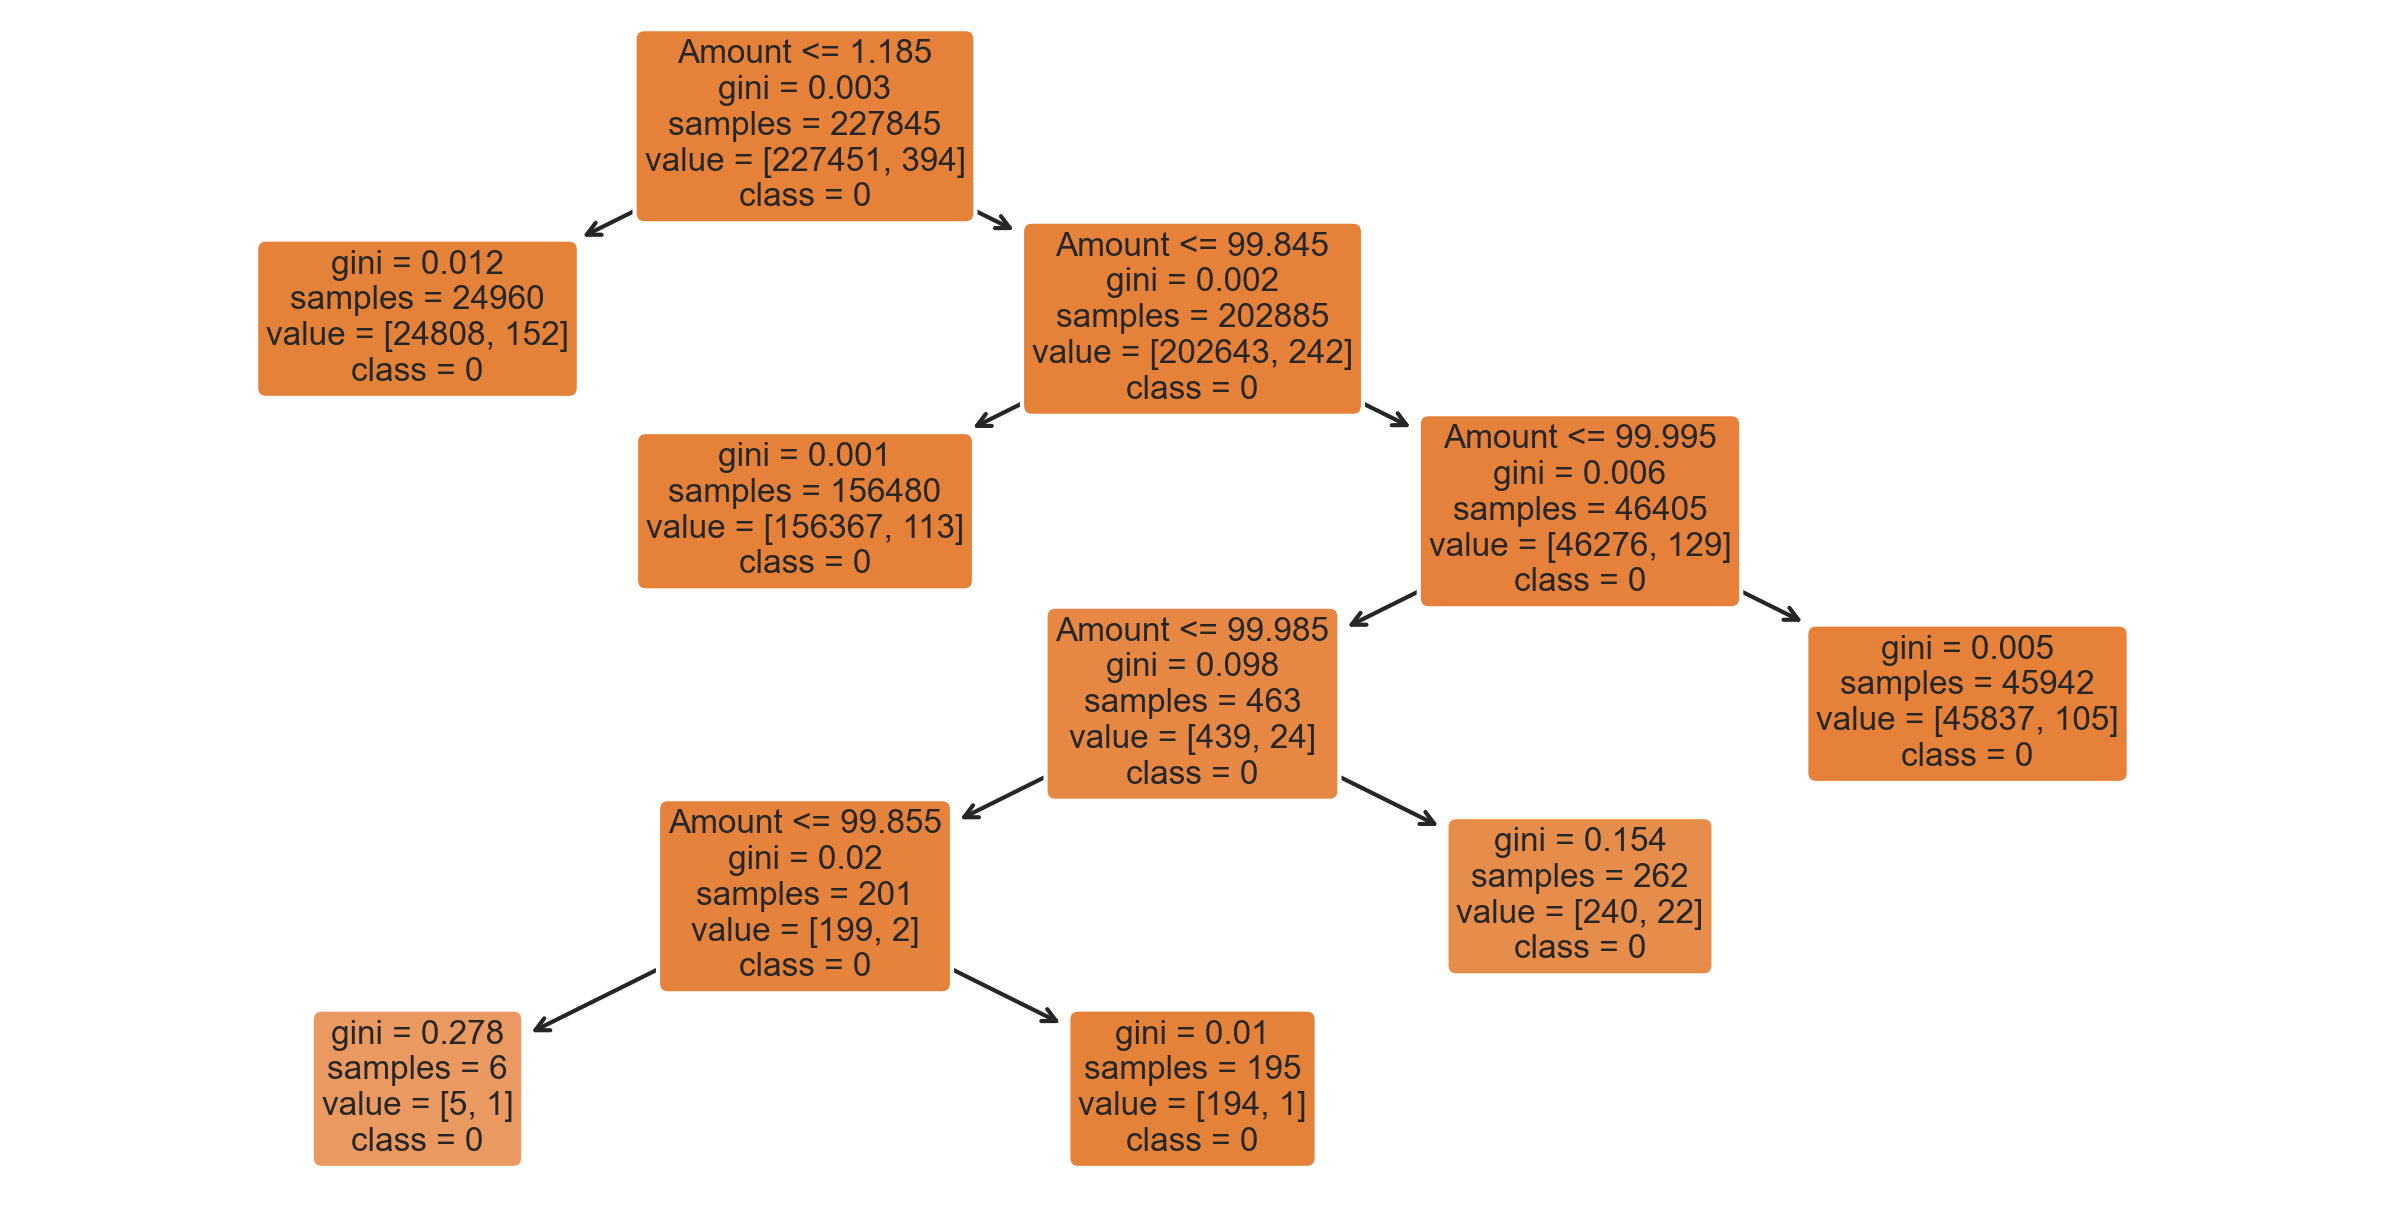

In [26]:
amount = train_data_pl['Amount'].to_numpy()
target = train_data_pl[CONFIG.TARGET].to_numpy()

# 拟合一个小的分类树
clf = DecisionTreeClassifier(max_leaf_nodes=6, random_state=CONFIG.RANDOM_STATE)
clf.fit(amount.reshape(-1, 1), target)
# 绘制树结构
plt.figure(figsize=(10, 5), dpi=300)
plot_tree(clf, feature_names=['Amount'], class_names=['0', '1'], 
          filled=True, rounded=True)
plt.show()

In [27]:
# 查看阈值
clf.tree_.threshold
# -2 是 sklearn 决策树内部约定的 叶子节点标志值，每个叶子节点不再划分数据

array([ 1.185     , -2.        , 99.84499741, -2.        , 99.99499893,
       99.98500061, -2.        , 99.85499954, -2.        , -2.        ,
       -2.        ])

In [28]:
# 提取分箱边界
thresholds = np.sort(clf.tree_.threshold[clf.tree_.threshold != -2])
bins = [-np.inf] + list(thresholds) + [np.inf]
np.digitize(amount, bins=bins, right=False) - 1

array([5, 1, 1, ..., 1, 1, 5], dtype=int64)

In [29]:
# 整合代码
X_train = train_data_pl.select(CONFIG.NUMERIC_COLS)
y_train = train_data_pl.select(CONFIG.TARGET)
X_test = test_data_pl.select(CONFIG.NUMERIC_COLS)

output_columns = []
for col in CONFIG.NUMERIC_COLS:
    # 拟合分类树
    clf = DecisionTreeClassifier(max_leaf_nodes=5)
    clf.fit(X_train.select(col).to_numpy(), y_train.to_numpy().ravel())

    # 提取决策边界
    thresholds = np.sort(clf.tree_.threshold[clf.tree_.threshold != -2])
    bins = [-np.inf] + list(thresholds) + [np.inf]

    # 对 test_data 进行分箱
    bin_col = pl.Series(
        name=f"{col}_bin",
        values=np.digitize(X_test[col].to_numpy(), bins=bins, right=False) - 1
    )
    output_columns.append(bin_col)
pl.DataFrame(output_columns)

Time_bin,V1_bin,V2_bin,V3_bin,V4_bin,V5_bin,V6_bin,V7_bin,V8_bin,V9_bin,V10_bin,V11_bin,V12_bin,V13_bin,V14_bin,V15_bin,V16_bin,V17_bin,V18_bin,V19_bin,V20_bin,V21_bin,V22_bin,V23_bin,V24_bin,V25_bin,V26_bin,V27_bin,V28_bin,Amount_bin
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
4,4,0,4,0,4,4,4,2,4,4,0,4,2,4,3,4,4,4,0,2,1,2,2,4,2,0,2,2,1
4,4,0,4,0,4,4,4,2,4,4,0,4,0,4,3,4,4,4,0,2,1,2,2,2,2,2,2,2,1
4,4,0,4,0,3,4,4,2,4,4,0,4,4,4,3,4,4,4,0,4,1,2,4,2,2,2,2,2,4
4,4,0,4,0,4,4,4,2,4,4,0,4,2,4,3,4,4,4,0,4,1,2,0,2,2,0,2,2,4
4,4,0,4,0,4,4,4,2,4,4,0,4,2,4,3,4,4,4,0,2,1,2,2,2,2,2,2,2,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,4,0,4,0,4,4,4,2,4,4,0,4,4,4,3,4,4,4,0,2,1,2,2,4,2,0,2,2,1
4,4,0,4,0,4,4,4,2,4,4,0,4,0,4,3,4,4,4,0,2,1,2,2,2,2,0,2,2,1
4,4,0,4,0,4,4,4,2,4,4,0,4,2,4,3,4,4,4,0,2,1,2,2,2,2,0,2,2,1


# **4. 不平衡数据集的处理**

## 4.1 随机欠采样

In [30]:
df = data_pl.clone()
df = df.sample(fraction=1)

# 获取平衡数据集
fraud_df = df.filter(pl.col('Class') == 1)
non_fraud_df = df.filter(pl.col('Class') == 0)[:len(fraud_df)]

normal_distribution_df = pl.concat([fraud_df, non_fraud_df])

# 随机打乱
random_sample_df = normal_distribution_df.sample(fraction=1, shuffle=True)
random_sample_df.head()

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
279.0,-0.857063,0.204627,2.186985,-0.045589,0.472689,-0.18745,0.435892,0.010475,-0.182091,-0.369533,0.599526,0.285636,-0.803135,-0.103033,-0.835168,-0.084479,-0.353418,0.105381,0.928781,0.175356,-0.237293,-0.611724,-0.190796,0.003336,0.212666,0.295664,-0.17526,-0.165614,19.29,0
152.0,0.09549,-2.557694,-1.134055,-0.43577,0.728493,4.090476,-0.429329,0.896879,1.004244,-0.67362,-0.561046,0.419629,0.021972,-0.274255,-0.03743,0.286635,-0.336254,-0.068412,0.644496,1.280124,0.080098,-1.038538,-0.489645,1.10844,0.072603,0.893183,-0.146017,0.11311,614.87,0
77154.0,-0.715414,0.60859,1.155501,-0.267565,-0.563748,-0.618898,0.698308,0.069837,-0.133341,-1.025335,1.500629,-0.417898,-1.590295,-1.074999,0.288234,1.377769,0.223887,1.311073,-0.896072,-0.186978,0.130749,0.239389,-0.090227,0.411572,-0.216126,0.353896,-0.062361,0.008433,129.0,1
66037.0,0.286302,1.399345,-1.682503,3.864377,-1.185373,-0.341732,-2.53938,0.768378,-1.547882,-2.659718,2.621588,-3.462362,-1.0543,-4.955823,-1.400274,-2.339943,-5.197794,-1.342814,0.288847,0.27036,0.352456,-0.243678,-0.194079,-0.172201,0.742237,0.12779,0.569731,0.291206,7.53,1
41582.0,-1.048005,1.300219,-0.180401,2.589843,-1.164794,0.031823,-2.175778,0.699072,-1.140208,-3.226787,3.490805,-2.454339,0.177189,-5.160608,-0.686114,-3.996145,-4.695563,-1.819161,1.46108,0.644993,0.549014,0.624321,-0.136663,0.131738,0.030921,-0.176701,0.504898,0.069882,39.45,1


In [31]:
(
    random_sample_df['Class']
    .value_counts()
    .with_columns([
        (pl.col('count') / pl.col('count').sum() * 100)
        .alias('percentage(%)')
    ])
)

Class,count,percentage(%)
i64,u32,f64
1,492,50.0
0,492,50.0


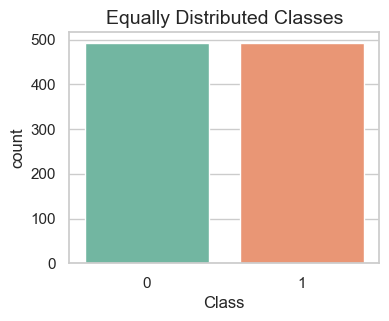

In [32]:
plt.figure(figsize=(4, 3))
sns.countplot(data=random_sample_df, x='Class', palette='Set2')
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

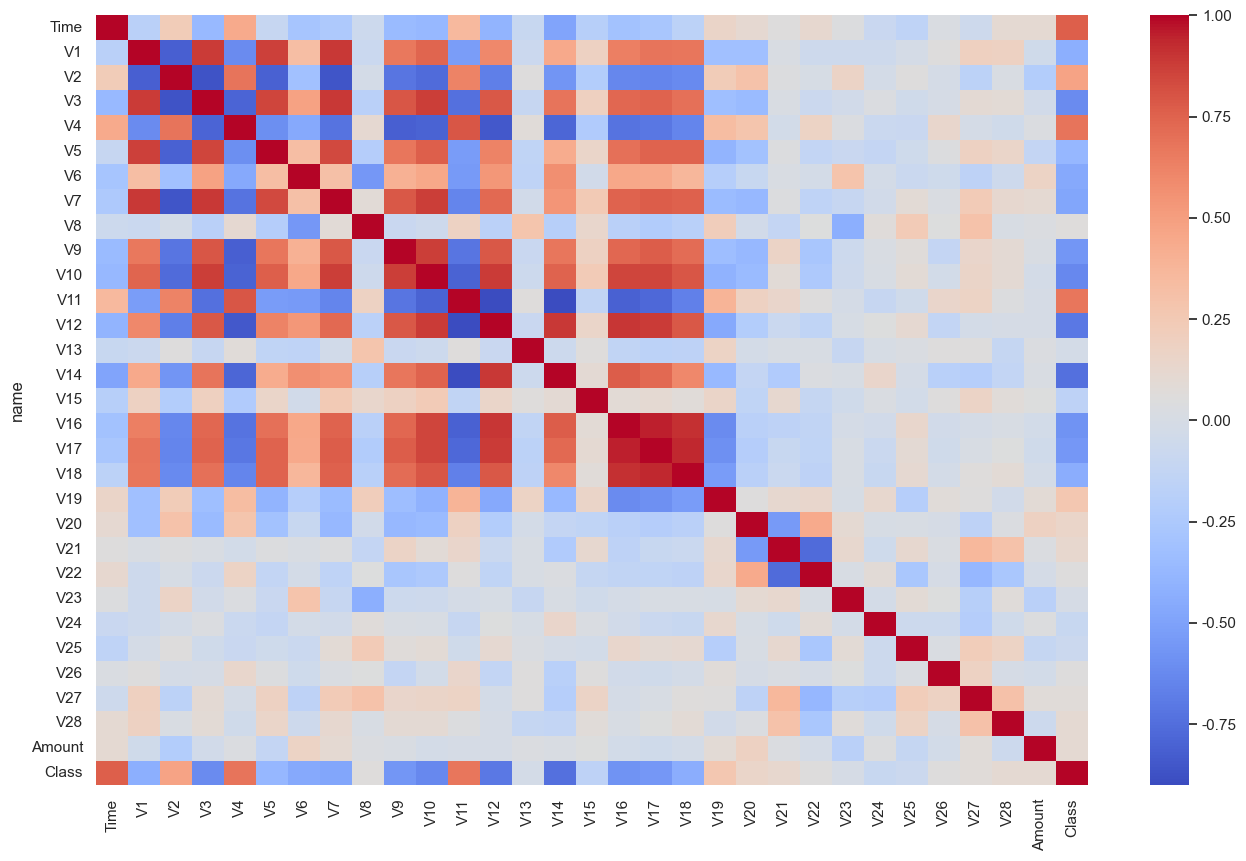

In [33]:
corr = random_sample_df.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(
    (
        corr\
        .with_columns([
            pl.Series(corr.columns).alias('name')
        ])
        .select(['name'] + corr.columns)
        .to_pandas()
        .set_index('name')
    ),
    cmap='coolwarm',
    annot_kws={'size': 20}
)
plt.show()

## 4.2 NearMiss

In [34]:
X = data_pl.drop('Class')
y = data_pl['Class']

nm = NearMiss(version=1, n_neighbors=3)
nm_X, nm_y = nm.fit_resample(X.to_numpy(), y.to_numpy())

# 重新合并为pl.DataFrame，之后随机打乱
nm_X_pl = pl.DataFrame(nm_X, schema=X.columns)
nm_y_pl = pl.DataFrame(nm_y, schema=['Class'])
nm_df = pl.concat([nm_X_pl, nm_y_pl], how='horizontal').sample(fraction=1, shuffle=True)

Counter(nm_df['Class'])

Counter({1: 492, 0: 492})

## 4.3 SMOTE

In [35]:
smote = SMOTE(random_state=CONFIG.RANDOM_STATE, k_neighbors=5)
smote_x, smote_y = smote.fit_resample(X.to_numpy(), y.to_numpy())

# 重新合并为pl.DataFrame,之后随机打乱
smote_x_pl = pl.DataFrame(smote_x, schema=X.columns)
smote_y_pl = pl.DataFrame(smote_y, schema=['Class'])
smote_df = pl.concat([smote_x_pl, smote_y_pl], how='horizontal').sample(fraction=1, shuffle=True)

Counter(smote_df['Class'])

Counter({0: 284315, 1: 284315})

## 4.4 ADASYN

In [36]:
adasyn = ADASYN(random_state=CONFIG.RANDOM_STATE, n_neighbors=5)
adasyn_x, adasyn_y = adasyn.fit_resample(X.to_numpy(), y.to_numpy())

# 重新合并为pl.DataFrame,之后随机打乱v
adasyn_x_pl = pl.DataFrame(adasyn_x, schema=X.columns)
adasyn_y_pl = pl.DataFrame(adasyn_y, schema=['Class'])
adasyn_df = pl.concat([adasyn_x_pl, adasyn_y_pl], how='horizontal').sample(fraction=1, shuffle=True)

Counter(adasyn_df['Class'])

Counter({0: 284315, 1: 284298})

# **5. 模型构建与调优**

In [37]:
seed_everything()

X = data_pl.drop(CONFIG.TARGET).to_pandas()
y = data_pl[CONFIG.TARGET].to_pandas()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=CONFIG.RANDOM_STATE)

Set Seed = 2025


## 5.1 LogisticRegression

In [38]:
# 定义预处理步骤
logistic_precessor = ColumnTransformer([
    ('num', StandardScaler(), CONFIG.NUMERIC_COLS)
])

logistic_model = LogisticRegression(random_state=CONFIG.RANDOM_STATE)

# 定义采样方法
# ['random_usample', 'cluster_clean', 'kmeans_smote', 'borderline_smote', 'smote_enn', 'adasyn']
SAMPLING_NAME = 'adasyn'

### 5.1.1 base模型训练

#### 5.1.1.1 不做采样，直接训练模型

In [39]:
logistic_pipeline = Pipeline([
    ('preprocessor', logistic_precessor),
    ('logistic_model', clone(LogisticRegression()))
])
logistic_pipeline.fit(X_train, y_train)
eval_metric_data(logistic_pipeline, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,weighted_score
train_eval,0.999210,0.626904,0.882143,0.732938,0.813379,0.745745
test_eval,0.999122,0.602041,0.842857,0.702381,0.800924,0.719959


In [40]:
"""
未采样模型的"虚假"高精确率
# 当欺诈率0.1%时，precision = TP/(TP+FP) = 0/(0+0) → 未定义
# sklearn默认处理为1.0 → 误导性结果!
"""

'\n未采样模型的"虚假"高精确率\n# 当欺诈率0.1%时，precision = TP/(TP+FP) = 0/(0+0) → 未定义\n# sklearn默认处理为1.0 → 误导性结果!\n'

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.60      0.70        98

    accuracy                           1.00     56962
   macro avg       0.92      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



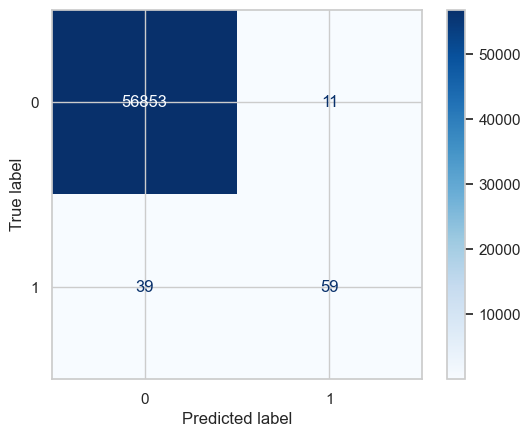

In [41]:
# 查看混淆矩阵
y_pred = logistic_pipeline.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
print('Classification Report: \n', classification_report(y_test, y_pred))

#### 5.1.1.2 采样后进行模型训练

In [42]:
# 构建完整流程的Pipeline
logistic_pipeline = Pipeline(steps=[
    ('data_preprocessor', logistic_precessor),
    
    # ('random_usample', CONFIG.SAMPLING.get('random_usample')),
    # ('adasyn', CONFIG.SAMPLING.get('adasyn')),
    # ('kmeans_smote', CONFIG.SAMPLING.get('kmeans_smote')),
    # ('smote_enn', CONFIG.SAMPLING.get('smote_enn')),
    # ('borderline_smote', CONFIG.SAMPLING.get('borderline_smote')),

    (SAMPLING_NAME, CONFIG.SAMPLING.get(SAMPLING_NAME)),
    ('logistic_model', clone(LogisticRegression()))
])

logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Time', 'V1', 'V2', 'V3',
                                                   'V4', 'V5', 'V6', 'V7', 'V8',
                                                   'V9', 'V10', 'V11', 'V12',
                                                   'V13', 'V14', 'V15', 'V16',
                                                   'V17', 'V18', 'V19', 'V20',
                                                   'V21', 'V22', 'V23', 'V24',
                                                   'V25', 'V26', 'V27', 'V28',
                                                   'Amount'])])),
                ('adasyn',
                 ADASYN(random_state=2025, sampling_strategy='minority')),
                ('logistic_model', LogisticRegression())])

In [43]:
eval_metric_data(logistic_pipeline, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,weighted_score
train_eval,0.912682,0.956853,0.018613,0.036515,0.934729,0.579610
test_eval,0.911292,0.938776,0.017902,0.035135,0.925010,0.570434


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     56864
           1       0.02      0.94      0.04        98

    accuracy                           0.91     56962
   macro avg       0.51      0.93      0.49     56962
weighted avg       1.00      0.91      0.95     56962



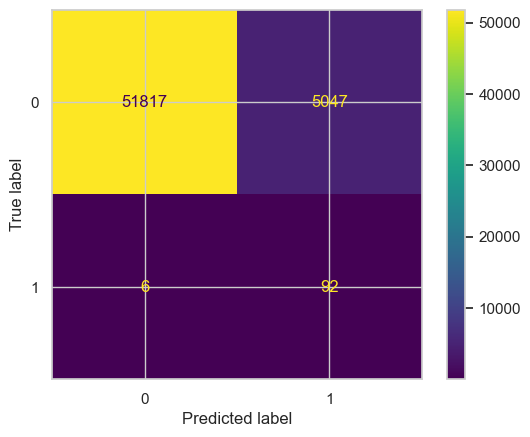

In [44]:
# 查看混淆矩阵
y_pred = logistic_pipeline.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print('Classification Report: \n', classification_report(y_test, y_pred))

### 5.1.2 Optuna 超参数调优

In [45]:
lr_model_object = partial(
    lr_model_objective,
    X_train=X_train,
    y_train=y_train,
    preprocessor=logistic_precessor,
    # ['random_usample', 'nearmiss', 'smote', 'adasyn']
    sampling='random_usample'
)

lr_model_study = optuna.create_study(direction='maximize',
                                     sampler=optuna.samplers.TPESampler(seed=CONFIG.RANDOM_STATE))
lr_model_study.optimize(lr_model_object, n_trials=20, 
                        n_jobs=-1, show_progress_bar=True)

[I 2025-06-17 15:39:34,622] A new study created in memory with name: no-name-3dab8be6-759e-4f67-b2c9-00f3deb38bec


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-17 15:39:54,521] Trial 4 finished with value: 0.5767031478789983 and parameters: {'penalty_solver': ('l2', 'liblinear'), 'C': 14032.208605577907, 'max_iter': 871}. Best is trial 4 with value: 0.5767031478789983.
[I 2025-06-17 15:39:54,721] Trial 0 finished with value: 0.574072642906887 and parameters: {'penalty_solver': ('l2', 'liblinear'), 'C': 69.6559678349081, 'max_iter': 641}. Best is trial 4 with value: 0.5767031478789983.
[I 2025-06-17 15:39:54,972] Trial 11 finished with value: 0.7263749547715972 and parameters: {'penalty_solver': ('l2', 'sag'), 'C': 0.0032519468986212294, 'max_iter': 861}. Best is trial 11 with value: 0.7263749547715972.
[I 2025-06-17 15:39:55,125] Trial 5 finished with value: 0.5776871378854602 and parameters: {'penalty_solver': ('elasticnet', 'saga'), 'C': 1146.0971616423494, 'max_iter': 141, 'l1_ratio': 0.24094435170323067}. Best is trial 11 with value: 0.7263749547715972.
[I 2025-06-17 15:39:55,394] Trial 7 finished with value: 0.578393904170948 

In [46]:
optuna.visualization.plot_optimization_history(lr_model_study).show()
optuna.visualization.plot_param_importances(lr_model_study).show()
optuna.visualization.plot_slice(lr_model_study).show()

In [47]:
lr_model_study.best_params

{'penalty_solver': ('l2', 'newton-cg'),
 'C': 6.741668457228274e-05,
 'max_iter': 311}

In [48]:
# 从 study 中取出最优参数
best_params = lr_model_study.best_params
penalty, solver = best_params['penalty_solver']

# 构造参数字典
lr_params = {
    'penalty': penalty,
    'solver': solver,
    'C': best_params['C'],
    'max_iter': best_params['max_iter'],
    'random_state': CONFIG.RANDOM_STATE
}

# 仅当为 elasticnet 时添加 l1_ratio
if penalty == 'elasticnet':
    lr_params['l1_ratio'] = best_params['l1_ratio']

# 初始化模型并构建 Pipeline
best_lr_model = LogisticRegression(**lr_params)

final_lr_pipeline = Pipeline([
    ('data_preprocessor', logistic_precessor),
    (SAMPLING_NAME, CONFIG.SAMPLING.get(SAMPLING_NAME)),
    ('logistic_model', best_lr_model)
])

final_lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Time', 'V1', 'V2', 'V3',
                                                   'V4', 'V5', 'V6', 'V7', 'V8',
                                                   'V9', 'V10', 'V11', 'V12',
                                                   'V13', 'V14', 'V15', 'V16',
                                                   'V17', 'V18', 'V19', 'V20',
                                                   'V21', 'V22', 'V23', 'V24',
                                                   'V25', 'V26', 'V27', 'V28',
                                                   'Amount'])])),
                ('adasyn',
                 ADASYN(random_state=2025, sampling_strategy='minority')),
                ('logistic_model',
                 LogisticRegression(C=6.741668457228274e-05, max_iter=311,
                                    random_state=2025, solver='newton-cg'))])

In [49]:
eval_metric_data(final_lr_pipeline, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,weighted_score
train_eval,0.927315,0.951777,0.022167,0.043325,0.939524,0.581103
test_eval,0.925722,0.928571,0.021089,0.041242,0.927144,0.569253


In [50]:
# 对比其他模型或方法
eval_metric_data(logistic_pipeline, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,weighted_score
train_eval,0.912682,0.956853,0.018613,0.036515,0.934729,0.579610
test_eval,0.911292,0.938776,0.017902,0.035135,0.925010,0.570434


### 5.1.3 阈值移动调优

In [51]:
lr_thr_mdoel_objective = partial(
    lr_thr_model_objective,
    X_train=X_train,
    y_train=y_train,
    preprocessor=logistic_precessor,
    # ['random_usample', 'nearmiss', 'smote', 'adasyn']
    sampling='random_usample'
)

lr_thr_model_study = optuna.create_study(direction='maximize',
                                         sampler=optuna.samplers.TPESampler(seed=CONFIG.RANDOM_STATE))
lr_thr_model_study.optimize(lr_thr_mdoel_objective, n_trials=20,
                            n_jobs=-1, show_progress_bar=True)

[I 2025-06-17 15:40:09,475] A new study created in memory with name: no-name-3e6c43ff-b85d-458f-bf1d-3132419b4b48


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-17 15:40:27,812] Trial 0 finished with value: 0.12491353771204108 and parameters: {'penalty_solver': ('l1', 'saga'), 'C': 1.9130465768099184e-05, 'max_iter': 711, 'threshold': 0.9482456037956449}. Best is trial 0 with value: 0.12491353771204108.
[I 2025-06-17 15:40:27,997] Trial 15 finished with value: 0.16711628880504206 and parameters: {'penalty_solver': ('l1', 'saga'), 'C': 0.0026373565704491684, 'max_iter': 781, 'threshold': 0.9895371771855838}. Best is trial 15 with value: 0.16711628880504206.
[I 2025-06-17 15:40:28,159] Trial 12 finished with value: 0.47612281566125464 and parameters: {'penalty_solver': ('l1', 'saga'), 'C': 7.9473424837279145, 'max_iter': 1, 'threshold': 0.017226551948064328}. Best is trial 12 with value: 0.47612281566125464.
[I 2025-06-17 15:40:28,371] Trial 14 finished with value: 0.5611169010607668 and parameters: {'penalty_solver': ('l2', 'liblinear'), 'C': 4177.960241184276, 'max_iter': 131, 'threshold': 0.09710292018317868}. Best is trial 14 with

In [52]:
optuna.visualization.plot_optimization_history(lr_thr_model_study).show()
optuna.visualization.plot_param_importances(lr_thr_model_study).show()
optuna.visualization.plot_slice(lr_thr_model_study).show()

In [53]:
# 从 study 中取出最优参数
best_params = lr_thr_model_study.best_params
penalty, solver = best_params['penalty_solver']

# 构造参数字典
lr_thr_params = {
    'penalty': penalty,
    'solver': solver,
    'C': best_params['C'],
    'max_iter': best_params['max_iter'],
    'thr': best_params['threshold'],
}

# 仅当为 elasticnet 时添加 l1_ratio
if penalty == 'elasticnet':
    lr_thr_params['l1_ratio'] = best_params['l1_ratio']

# 初始化模型并构建 Pipeline
best_lr_thr_model = LR_Threshold(**lr_thr_params)

final_lr_thr_pipeline = Pipeline([
    ('data_preprocessor', logistic_precessor),
    (SAMPLING_NAME, CONFIG.SAMPLING.get(SAMPLING_NAME)),
    ('LR_THR_Model', best_lr_thr_model)
])

final_lr_thr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Time', 'V1', 'V2', 'V3',
                                                   'V4', 'V5', 'V6', 'V7', 'V8',
                                                   'V9', 'V10', 'V11', 'V12',
                                                   'V13', 'V14', 'V15', 'V16',
                                                   'V17', 'V18', 'V19', 'V20',
                                                   'V21', 'V22', 'V23', 'V24',
                                                   'V25', 'V26', 'V27', 'V28',
                                                   'Amount'])])),
                ('adasyn',
                 ADASYN(random_state=2025, sampling_strategy='minority')),
                ('LR_THR_Model',
                 LR_Threshold(C=0.0004976525232427582, max_iter=711,
                              solver='newton-cg', thr=0.3779067193950767))])

In [54]:
eval_metric_data(final_lr_thr_pipeline, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,weighted_score
train_eval,0.858298,0.972081,0.011728,0.023176,0.915091,0.575992
test_eval,0.856536,0.959184,0.011377,0.022488,0.907771,0.569439


In [55]:
eval_metric_data(final_lr_pipeline, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,weighted_score
train_eval,0.927315,0.951777,0.022167,0.043325,0.939524,0.581103
test_eval,0.925722,0.928571,0.021089,0.041242,0.927144,0.569253


### 5.1.4 模型结果解释

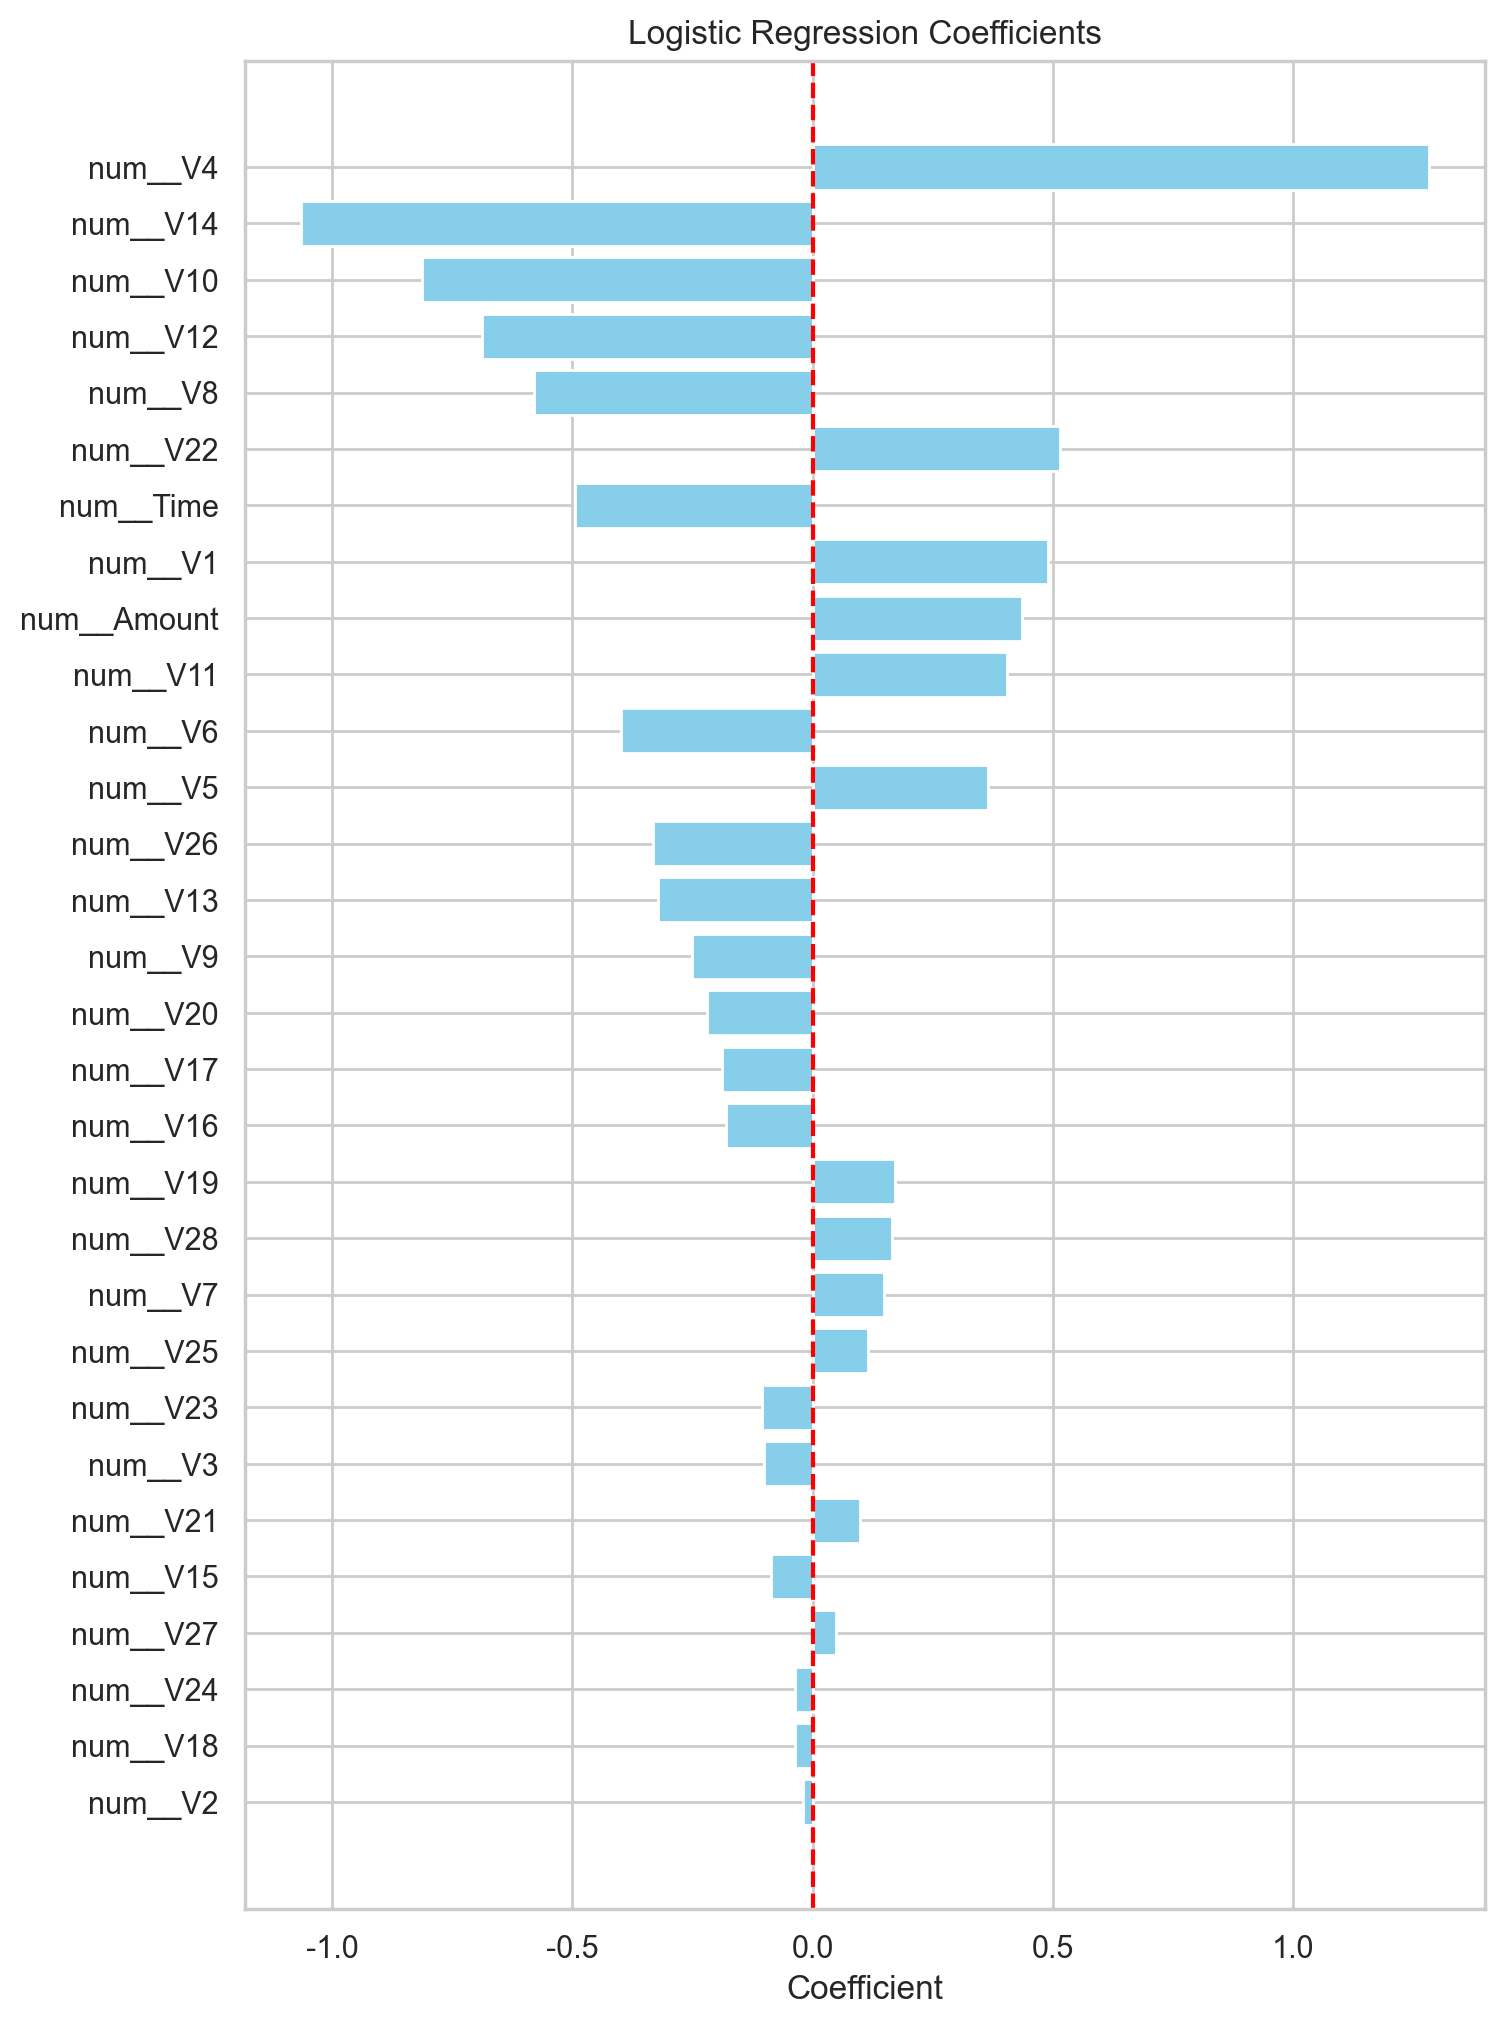

In [56]:
feature_nmaes = final_lr_thr_pipeline.named_steps['data_preprocessor'].get_feature_names_out()
lr_thr_model_coefs = final_lr_thr_pipeline.named_steps['LR_THR_Model'].coef_[0]
coef_map = dict(zip(feature_nmaes, lr_thr_model_coefs))

df_coef = pd.DataFrame(coef_map.items(), columns=['Feature', 'Coefficient'])
df_coef['abs_coef'] = df_coef['Coefficient'].abs()
df_coef.sort_values(by='abs_coef', ascending=True, inplace=True)

# 可视化
plt.figure(figsize=(8, 12), dpi=200)
plt.barh(df_coef['Feature'], df_coef['Coefficient'], color='skyblue')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient')
plt.show()

## 5.2 DecisionTree

In [57]:
# 定义预处理步骤
dt_precessor = ColumnTransformer([
    ('num', StandardScaler(), CONFIG.NUMERIC_COLS)
])

dt_model = DecisionTreeClassifier(random_state=CONFIG.RANDOM_STATE)

# 定义采样方法
SAMPLING_NAME = 'adasyn'

### 5.2.1 base模型训练

#### 5.2.1.1 不做采样，直接训练模型

In [58]:
dt_pipeline = Pipeline([
    ('preprocessor', dt_precessor),
    ('dt_model', clone(DecisionTreeClassifier()))
])
dt_pipeline.fit(X_train, y_train)
eval_metric_data(dt_pipeline, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,weighted_score
train_eval,1.000000,1.000000,1.00,1.000000,1.000000,1.000000
test_eval,0.999228,0.785714,0.77,0.777778,0.892655,0.807701


#### 5.2.1.2 采样后进行模型训练

In [59]:
# 构建完整流程的Pipeline
dt_pipeline = Pipeline(steps=[
    ('data_preprocessor', dt_precessor),
    (SAMPLING_NAME, CONFIG.SAMPLING.get(SAMPLING_NAME)),
    ('dt_model', clone(DecisionTreeClassifier()))
])

dt_pipeline.fit(X_train, y_train)
eval_metric_data(dt_pipeline, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,weighted_score
train_eval,1.0000,1.00000,1.000000,1.000000,1.00000,1.000000
test_eval,0.9977,0.72449,0.405714,0.520147,0.86133,0.654053


### 5.2.2 Optuna 超参数调优

In [60]:
dt_model_object = partial(
    dt_model_objective,
    X_train=X_train,
    y_train=y_train,
    preprocessor=dt_precessor,
    sampling='random_usample'
)

dt_model_study = optuna.create_study(direction='maximize',
                                   sampler=optuna.samplers.TPESampler(seed=CONFIG.RANDOM_STATE))
dt_model_study.optimize(dt_model_object, n_trials=20, 
                      n_jobs=-1, show_progress_bar=True)

# 可视化调参过程
optuna.visualization.plot_optimization_history(dt_model_study).show()
optuna.visualization.plot_param_importances(dt_model_study).show()
optuna.visualization.plot_slice(dt_model_study).show()


[I 2025-06-17 15:42:44,056] A new study created in memory with name: no-name-6f91a89f-2166-4785-b763-4039266d243a


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-17 15:43:11,770] Trial 4 finished with value: 0.5433673596363956 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_smaples_split': 8, 'min_samples_leaf': 9, 'max_leaf_nodes': 100, 'max_features': 'log2', 'cpp_alpha': 0.21018439032283193}. Best is trial 4 with value: 0.5433673596363956.
[I 2025-06-17 15:43:11,988] Trial 7 finished with value: 0.12491353771204108 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_smaples_split': 9, 'min_samples_leaf': 11, 'max_leaf_nodes': 54, 'max_features': 'log2', 'cpp_alpha': 0.365272699847814}. Best is trial 4 with value: 0.5433673596363956.
[I 2025-06-17 15:43:12,187] Trial 1 finished with value: 0.12491353771204108 and parameters: {'criterion': 'gini', 'max_depth': 2, 'min_smaples_split': 3, 'min_samples_leaf': 5, 'max_leaf_nodes': 64, 'max_features': 'log2', 'cpp_alpha': 0.47263482333656326}. Best is trial 4 with value: 0.5433673596363956.
[I 2025-06-17 15:43:12,402] Trial 3 finished with value: 0.5268644881289957 a

In [61]:
# 从 study 中取出最优参数
best_params = dt_model_study.best_params

# 构造参数字典
dt_params = {
    'criterion': best_params['criterion'],
    'max_depth': best_params['max_depth'],
    'min_samples_split': best_params['min_smaples_split'],
    'min_samples_leaf': best_params['min_samples_leaf'],
    'max_leaf_nodes': best_params['max_leaf_nodes'],
    'max_features': best_params['max_features'],
    'ccp_alpha': best_params['cpp_alpha'],
    'random_state': CONFIG.RANDOM_STATE
}

# 初始化模型并构建 Pipeline
best_dt_model = DecisionTreeClassifier(**dt_params)

final_dt_pipeline = Pipeline([
    ('data_preprocessor', dt_precessor),
    (SAMPLING_NAME, CONFIG.SAMPLING.get(SAMPLING_NAME)),
    ('dt_model', best_dt_model)
])

final_dt_pipeline.fit(X_train, y_train)
eval_metric_data(final_dt_pipeline, X_train, y_train, X_test, y_test)


,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,weighted_score
train_eval,0.001729,1.0,0.001729,0.003453,0.5,0.476123
test_eval,0.001720,1.0,0.001720,0.003435,0.5,0.476117


### 5.2.3 阈值移动调优

In [62]:
dt_thr_model_object = partial(
    dt_thr_model_objective,
    X_train=X_train,
    y_train=y_train,
    preprocessor=dt_precessor,
    sampling='random_usample'
)

dt_thr_model_study = optuna.create_study(direction='maximize',
                                       sampler=optuna.samplers.TPESampler(seed=CONFIG.RANDOM_STATE))
dt_thr_model_study.optimize(dt_thr_model_object, n_trials=20,
                          n_jobs=-1, show_progress_bar=True)

# 可视化调参过程
optuna.visualization.plot_optimization_history(dt_thr_model_study).show()
optuna.visualization.plot_param_importances(dt_thr_model_study).show()
optuna.visualization.plot_slice(dt_thr_model_study).show()


[I 2025-06-17 15:43:35,650] A new study created in memory with name: no-name-ce62eb1c-9787-4ecf-a134-edd75c0f996d


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-17 15:44:01,207] Trial 7 finished with value: 0.47612281566125464 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_smaples_split': 6, 'min_samples_leaf': 11, 'max_leaf_nodes': 62, 'max_features': 'sqrt', 'cpp_alpha': 0.4952428437994465, 'threshold': 0.40736128096672974}. Best is trial 7 with value: 0.47612281566125464.
[I 2025-06-17 15:44:01,458] Trial 0 finished with value: 0.47612281566125464 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_smaples_split': 5, 'min_samples_leaf': 20, 'max_leaf_nodes': 58, 'max_features': 'log2', 'cpp_alpha': 0.4163722892999353, 'threshold': 0.37913654046830403}. Best is trial 7 with value: 0.47612281566125464.
[I 2025-06-17 15:44:01,677] Trial 3 finished with value: 0.47612281566125464 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_smaples_split': 9, 'min_samples_leaf': 19, 'max_leaf_nodes': 96, 'max_features': 'sqrt', 'cpp_alpha': 0.2263970539802863, 'threshold': 0.15783886879362488}. Best is trial 7 w

In [63]:
# 从 study 中取出最优参数
best_params = dt_thr_model_study.best_params

# 构造参数字典
dt_thr_params = {
    'criterion': best_params['criterion'],
    'max_depth': best_params['max_depth'],
    'min_samples_split': best_params['min_smaples_split'],
    'min_samples_leaf': best_params['min_samples_leaf'],
    'max_leaf_nodes': best_params['max_leaf_nodes'],
    'max_features': best_params['max_features'],
    'ccp_alpha': best_params['cpp_alpha'],
    'thr': best_params['threshold']
}

# 初始化模型并构建 Pipeline
best_dt_thr_model = DT_Threshold(**dt_thr_params)

final_dt_thr_pipeline = Pipeline([
    ('data_preprocessor', dt_precessor),
    (SAMPLING_NAME, CONFIG.SAMPLING.get(SAMPLING_NAME)),
    ('DT_THR_Model', best_dt_thr_model)
])

final_dt_thr_pipeline.fit(X_train, y_train)
eval_metric_data(final_dt_thr_pipeline, X_train, y_train, X_test, y_test)

# 对比其他模型或方法
eval_metric_data(final_dt_pipeline, X_train, y_train, X_test, y_test)


,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,weighted_score
train_eval,0.001729,1.0,0.001729,0.003453,0.5,0.476123
test_eval,0.001720,1.0,0.001720,0.003435,0.5,0.476117


## 5.3 XGBOOST

In [64]:
# 定义预处理步骤
xgb_precessor = ColumnTransformer([
    ('num', StandardScaler(), CONFIG.NUMERIC_COLS)
])

xgb_model = XGBClassifier(random_state=CONFIG.RANDOM_STATE,
                         use_label_encoder=False,
                         eval_metric='logloss')

# 定义采样方法
SAMPLING_NAME = 'adasyn'

### 5.3.1 base模型训练

#### 5.3.1.1 不做采样，直接训练模型

In [65]:
xgb_pipeline = Pipeline([
    ('preprocessor', xgb_precessor),
    ('xgb_model', clone(XGBClassifier(random_state=CONFIG.RANDOM_STATE,
                                     use_label_encoder=False,
                                     eval_metric='logloss')))
])
xgb_pipeline.fit(X_train, y_train)
eval_metric_data(xgb_pipeline, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,weighted_score
train_eval,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
test_eval,0.999631,0.795918,0.987342,0.881356,0.89795,0.876781


#### 5.3.1.2 采样后进行模型训练

In [66]:
# 构建完整流程的Pipeline
xgb_pipeline = Pipeline(steps=[
    ('data_preprocessor', xgb_precessor),
    (SAMPLING_NAME, CONFIG.SAMPLING.get(SAMPLING_NAME)),
    ('xgb_model', clone(XGBClassifier(random_state=CONFIG.RANDOM_STATE,
                                     use_label_encoder=False,
                                     eval_metric='logloss')))
])

xgb_pipeline.fit(X_train, y_train)
eval_metric_data(xgb_pipeline, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,weighted_score
train_eval,0.999982,1.000000,0.989950,0.994949,0.999991,0.996978
test_eval,0.999105,0.867347,0.691057,0.769231,0.933339,0.828952


### 5.3.2 Optuna 超参数调优

In [67]:
xgb_model_object = partial(
    xgb_model_objective,
    X_train=X_train,
    y_train=y_train,
    preprocessor=xgb_precessor,
    sampling='random_usample'
)

xgb_model_study = optuna.create_study(direction='maximize',
                                    sampler=optuna.samplers.TPESampler(seed=CONFIG.RANDOM_STATE))
xgb_model_study.optimize(xgb_model_object, n_trials=20, 
                       n_jobs=-1, show_progress_bar=True)

# 可视化调参过程
optuna.visualization.plot_optimization_history(xgb_model_study).show()
optuna.visualization.plot_param_importances(xgb_model_study).show()
optuna.visualization.plot_slice(xgb_model_study).show()


[I 2025-06-17 15:44:42,088] A new study created in memory with name: no-name-9034b829-3e60-46d0-bd5c-045f68b091ea


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-17 15:44:58,019] Trial 2 finished with value: 0.5779419265677294 and parameters: {'max_depth': 5, 'learning_rate': 0.24066359547655816, 'n_estimators': 24, 'subsample': 0.8962426461876832, 'colsample_bytree': 0.8995380466905852, 'reg_alpha': 0.00048576234863547914, 'reg_lambda': 0.0003177758844381285}. Best is trial 2 with value: 0.5779419265677294.
[I 2025-06-17 15:44:59,568] Trial 0 finished with value: 0.5903533540950099 and parameters: {'max_depth': 2, 'learning_rate': 0.11691705504550903, 'n_estimators': 51, 'subsample': 0.6052385848525914, 'colsample_bytree': 0.5292487307346996, 'reg_alpha': 0.0015702603905557277, 'reg_lambda': 3.4105533263332797}. Best is trial 0 with value: 0.5903533540950099.
[I 2025-06-17 15:45:03,125] Trial 7 finished with value: 0.5762989764270122 and parameters: {'max_depth': 6, 'learning_rate': 0.24584411131109868, 'n_estimators': 45, 'subsample': 0.6808059993087813, 'colsample_bytree': 0.6188458377504708, 'reg_alpha': 0.0523003623422266, 'reg_

In [68]:
# 从 study 中取出最优参数
best_params = xgb_model_study.best_params

# 构造参数字典
xgb_params = {
    'max_depth': best_params['max_depth'],
    'n_estimators': best_params['n_estimators'],
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_lambda': best_params['reg_lambda'],
    'reg_alpha': best_params['reg_alpha'],
    'random_state': CONFIG.RANDOM_STATE,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# 初始化模型并构建 Pipeline
best_xgb_model = XGBClassifier(**xgb_params)

final_xgb_pipeline = Pipeline([
    ('data_preprocessor', xgb_precessor),
    (SAMPLING_NAME, CONFIG.SAMPLING.get(SAMPLING_NAME)),
    ('xgb_model', best_xgb_model)
])

final_xgb_pipeline.fit(X_train, y_train)
eval_metric_data(final_xgb_pipeline, X_train, y_train, X_test, y_test)


,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,weighted_score
train_eval,0.930277,0.972081,0.023558,0.046000,0.951143,0.591929
test_eval,0.927478,0.928571,0.021590,0.042198,0.928024,0.569764


### 5.3.3 阈值移动调优

In [69]:
xgb_thr_model_object = partial(
    xgb_thr_model_objective,
    X_train=X_train,
    y_train=y_train,
    preprocessor=xgb_precessor,
    sampling='random_usample'
)

xgb_thr_model_study = optuna.create_study(direction='maximize',
                                        sampler=optuna.samplers.TPESampler(seed=CONFIG.RANDOM_STATE))
xgb_thr_model_study.optimize(xgb_thr_model_object, n_trials=20,
                           n_jobs=-1, show_progress_bar=True)

# 可视化调参过程
optuna.visualization.plot_optimization_history(xgb_thr_model_study).show()
optuna.visualization.plot_param_importances(xgb_thr_model_study).show()
optuna.visualization.plot_slice(xgb_thr_model_study).show()


[I 2025-06-17 15:45:27,259] A new study created in memory with name: no-name-1aaa7380-f888-45c0-9e4d-477429739ae7


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-17 15:45:47,647] Trial 15 finished with value: 0.6254470757588065 and parameters: {'max_depth': 5, 'learning_rate': 0.11015719578017394, 'n_estimators': 58, 'subsample': 0.6691611907250886, 'colsample_bytree': 0.696136206292828, 'reg_alpha': 0.2123233291308361, 'reg_lambda': 0.0024916763337361858, 'thr': 0.807026415278007}. Best is trial 15 with value: 0.6254470757588065.
[I 2025-06-17 15:45:47,879] Trial 2 finished with value: 0.6870591549404591 and parameters: {'max_depth': 6, 'learning_rate': 0.07400136628134336, 'n_estimators': 57, 'subsample': 0.8704741427058418, 'colsample_bytree': 0.9012355462036707, 'reg_alpha': 1.243687834980147, 'reg_lambda': 0.0012709308991809786, 'thr': 0.8901821062882517}. Best is trial 2 with value: 0.6870591549404591.
[I 2025-06-17 15:45:50,544] Trial 7 finished with value: 0.6023097489933064 and parameters: {'max_depth': 6, 'learning_rate': 0.11780499822534424, 'n_estimators': 78, 'subsample': 0.7494974376694759, 'colsample_bytree': 0.8507972

In [71]:
# 从 study 中取出最优参数
best_params = xgb_thr_model_study.best_params

# 构造参数字典
xgb_thr_params = {
    'max_depth': best_params['max_depth'],
    'n_estimators': best_params['n_estimators'],
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_lambda': best_params['reg_lambda'],
    'reg_alpha': best_params['reg_alpha'],
    'thr': best_params['thr']
}

# 初始化模型并构建 Pipeline
best_xgb_thr_model = XGB_Threshold(**xgb_thr_params)

final_xgb_thr_pipeline = Pipeline([
    ('data_preprocessor', xgb_precessor),
    (SAMPLING_NAME, CONFIG.SAMPLING.get(SAMPLING_NAME)),
    ('XGB_THR_Model', best_xgb_thr_model)
])

final_xgb_thr_pipeline.fit(X_train, y_train)
eval_metric_data(final_xgb_thr_pipeline, X_train, y_train, X_test, y_test)

# 对比其他模型或方法
eval_metric_data(final_xgb_pipeline, X_train, y_train, X_test, y_test)


,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,weighted_score
train_eval,0.930277,0.972081,0.023558,0.046000,0.951143,0.591929
test_eval,0.927478,0.928571,0.021590,0.042198,0.928024,0.569764


## 5.4 NN

In [ ]:
# TODO

## 5.5 模型融合

In [ ]:
# TODO

# # 欺诈检测专用模型管道
# fraud_pipeline = Pipeline([
#     ('preprocessor', RobustFraudPreprocessor()),  # 自定义预处理器
#     ('feature_selector', SelectFromModel(
#         estimator=ExtraTreesClassifier(n_estimators=50),
#         threshold='median'
#     )),
#     ('ensemble_sampler', FunctionSampler(func=resampling_strategy)),  # 自定义采样
#     ('model', StackingClassifier(
#         estimators=[
#             ('xgb', XGBClassifier(scale_pos_weight=200, eval_metric='aucpr')),
#             ('isolation', IsolationForest(contamination=0.001)),
#             ('lgbm', LGBMClassifier(class_weight={0:1, 1:50}))
#         ],
#         final_estimator=LogisticRegression(class_weight={0:1, 1:100}),
#         cv=5
#     ))
# ])